In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
cL_df = pd.read_csv('D:/pythonTest/DataShipJo/chicken_label_최종.csv', names=['아이디', '리뷰', 'Label'])
cL_df.head()

,아이디,리뷰,Label
0,pr**님,양이 많이 줄어든 느낌 이네요.,0
1,rh**님,혹시 hite 맥주 잘못 주신 것 아니에요? 생맥주라면 이런 맛이 안나오는데 ㅠㅠㅠ...,0
2,mo**님,사진 찍고싶었는데 까먹고 다 먹어버?f네용 담에 또 시킬게요!!!!,0
3,ky**님,냄새에 홀려 정신나간듯 먹다가 사진찍었네요ㅜㅜ 이케큰콜라가 서비스라니 번창하세요~~,0
4,wi**님,여긴 맛이 검증된곳이라.할말 없음,0


In [3]:
train_data, test_data = train_test_split(cL_df, test_size = 0.2, random_state=156)

In [4]:
# 훈련용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(train_data)) 

훈련용 리뷰 개수 : 44214


In [5]:
# 테스트용 리뷰 개수 출력
print('테스트용 리뷰 개수:',len(test_data)) 

테스트용 리뷰 개수: 11054


In [6]:
train_data.head()

,아이디,리뷰,Label
48250,pi**님,언제 먹어도 맛있어요 바삭하고 간장은 단짠의 조화,1
38094,손님,넘나 맛있네요,1
24181,bi**님,항상 너무 맛있습니다....????????,1
42699,im**님,딱 배달시간 맞춰서 왔고 맛있었습니다 ㅎㅎ,0
42746,ne**님,굿~~~~~~~~~,0


In [7]:
test_data.head()

,아이디,리뷰,Label
4366,jc**님,콜라도 같이 시켰는데 안 왔네요ㅠㅠㅠ 심야라 전화도 못 하고 …ㅠㅠ,0
52351,손님,혼자 먹을 치킨 시켜먹기 좋은 곳이에요. 다른메뉴로 두번째 시켜먹어봤습니다.,1
32247,dl**님,맛이 있었어요. 이전부터 자주 시켜 먹었던 그 맛,1
47219,손님,너무맛잇게잘먹엇습니다 소스도 친절하게 듬뿍챙겨주셔서감사해요 담에또주문할게요~~,1
49489,al**님,체인점 차이가 있을까 걱정했는데 여기도 맛있게 잘해주네요ㅎㅎ 잘 먹었습니다.,1


## 데이터 중복 유무 확인

In [8]:
# '리뷰'열과 'Label'열의 중복을 제외한 값의 개수
# print('훈련용 리뷰 개수 :',len(train_data)) 
print("리뷰, Label 열의 중복을 제외한 값의 개수 : ",train_data['리뷰'].nunique(), train_data['Label'].nunique())

### 1500개 정도의 중복 데이터 확인 ###

리뷰, Label 열의 중복을 제외한 값의 개수 :  33653 2


In [9]:
# '리뷰'열의 중복 제거
train_data.drop_duplicates(subset=['리뷰'], inplace=True)

In [10]:
print('훈련용 리뷰 개수 :',len(train_data)) 

훈련용 리뷰 개수 : 33653


<AxesSubplot:>

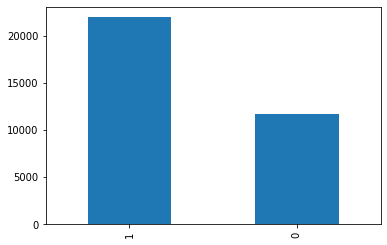

In [11]:
# train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(Label) 값의 분포
train_data['Label'].value_counts().plot(kind = 'bar')

In [12]:
# 'Label'의 값이 정확히 몇개인지 확인
print(train_data.groupby('Label').size().reset_index(name = 'count'))

### 0::부정:: , 1::긍정  ###

   Label  count
0      0  11702
1      1  21951


In [13]:
# train_data 결측값 확인
train_data.isna().sum()

아이디      0
리뷰       0
Label    0
dtype: int64

### 결측값 위치 확인
train_data.loc[train_data.document.isnull()]

### 결측값 제거
#### Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any') 
#### Null 값이 존재하는지 확인
print(train_data.isnull().values.any()) 

## 데이터 전처리

In [14]:
# 한글과 공백을 제외하고 모두 제거
train_data['리뷰'] = train_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:50]

,아이디,리뷰,Label
48250,pi**님,언제 먹어도 맛있어요 바삭하고 간장은 단짠의 조화,1
38094,손님,넘나 맛있네요,1
24181,bi**님,항상 너무 맛있습니다,1
42699,im**님,딱 배달시간 맞춰서 왔고 맛있었습니다 ㅎㅎ,0
42746,ne**님,굿,0
36504,jy**님,맛있어요,1
30247,da**님,맛있내요 양도 적당함,1
22382,as**님,늘맛나게먹고있습니다 멕시카나 양념존맛 뿌리고도 맛나더군요,1
17658,2w**님,근위튀김 소스가 누락 되었지만 맛 양 배달시간 등 나머지는 모두 만족입니다,1
38295,jj**님,순살세트인데 콜라페트 안줬어요,1


In [15]:
# 정규표현식 후 결측값 확인
train_data['리뷰'] = train_data['리뷰'].str.replace('^ +', "") 
train_data['리뷰'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

아이디        0
리뷰       409
Label      0
dtype: int64


In [16]:
# 결측값 확인
train_data.loc[train_data.리뷰.isnull()][:5]

,아이디,리뷰,Label
1746,57**님,NaN,0
14371,cu**님,NaN,0
656,db**님,NaN,0
14010,손님,NaN,0
15426,wl**님,NaN,0


In [17]:
# 결측값 삭제
train_data = train_data.dropna(how = 'any')
print(len(train_data))

33244


In [18]:
# test_data 또한 동일하게 전처리 진행

test_data.drop_duplicates(subset = ['리뷰'], inplace=True) # '리뷰'열에서 중복인 내용이 있다면 중복 제거
test_data['리뷰'] = test_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['리뷰'] = test_data['리뷰'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['리뷰'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 9782


In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [20]:
okt = Okt()
okt.morphs('와 이런 것도 치킨이라고 차라리 닭가슴살을 만드는 게 나을 뻔', stem = True)

['오다',
 '이렇다',
 '것',
 '도',
 '치킨',
 '이라고',
 '차라리',
 '닭',
 '가슴',
 '살',
 '을',
 '만들다',
 '게',
 '나다',
 '뻔']

In [21]:
### 토큰화 후 X_train 에 저장 ###
X_train = []
for sentence in tqdm(train_data['리뷰']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 33244/33244 [01:46<00:00, 311.56it/s]


In [22]:
print(X_train[:3])

[['언제', '먹다', '맛있다', '바삭', '하고', '간장', '단', '짜다', '조화'], ['넘다', '맛있다'], ['항상', '너무', '맛있다']]


In [23]:
### 토큰화 후 X_test 에 저장 ###
X_test = []
for sentence in tqdm(test_data['리뷰']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 9782/9782 [00:36<00:00, 269.66it/s]


### 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행한다

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
print(tokenizer.word_index)

{'먹다': 1, '맛있다': 2, '맛': 3, '배달': 4, '치킨': 5, '시키다': 6, '너무': 7, '좋다': 8, '자다': 9, '보다': 10, '오다': 11, '요': 12, '있다': 13, '많다': 14, '이다': 15, '주문': 16, '같다': 17, '다': 18, '양': 19, '감사하다': 20, '빠르다': 21, '양념': 22, '로': 23, '을': 24, '시간': 25, '안': 26, '후라이드': 27, '만': 28, '양도': 29, '진짜': 30, '또': 31, '없다': 32, 'ㅎㅎ': 33, '않다': 34, '항상': 35, '정말': 36, '서비스': 37, '소스': 38, '넘다': 39, '바삭': 40, '하고': 41, '더': 42, '역시': 43, '분': 44, '많이': 45, '튀김': 46, '리뷰': 47, '처음': 48, 'ㅠㅠ': 49, '순': 50, '다음': 51, '늦다': 52, '살': 53, '받다': 54, '오늘': 55, '네': 56, '최고': 57, '닭': 58, '되다': 59, '맵다': 60, '나': 61, '고': 62, '나다': 63, '빨리': 64, '못': 65, '괜찮다': 66, '반': 67, '그냥': 68, '여기': 69, '잇다': 70, '아니다': 71, '님': 72, '치즈볼': 73, '주다': 74, '엄청': 75, '것': 76, '아쉽다': 77, '서': 78, '생각': 79, '때': 80, '에서': 81, '사진': 82, '들다': 83, '조금': 84, '점': 85, '그렇다': 86, '짜다': 87, '떡': 88, '다른': 89, '이벤트': 90, 'ㅠ': 91, '찍다': 92, '식다': 93, '걸리다': 94, '믿다': 95, '링클': 96, '자주': 97, '뿌': 98, '인데': 99, '엔': 100, '제': 101, '오래': 102,

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11144
등장 빈도가 2번 이하인 희귀 단어의 수: 6601
단어 집합에서 희귀 단어의 비율: 59.233668341708544
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1881105525431916


In [27]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4544


In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
# 정수 인코딩이 되었는지 확인
print(X_train[:3])

[[315, 1, 2, 40, 41, 139, 283, 87, 1240], [39, 2], [35, 7, 2]]


In [30]:
# train_data에서 y_train과 y_test를 별도로 저장해준다
y_train = np.array(train_data['Label'])
y_test = np.array(test_data['Label'])

### 빈 샘플(empty samples) 제거
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미합니다. 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업을 하겠습니다. 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오겠습니다.

In [31]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [32]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print('X_train 샘플 제거 후 개수:',len(X_train))
print('y_train 샘플 제거 후 개수:',len(y_train))

X_train 샘플 제거 후 개수: 33116
y_train 샘플 제거 후 개수: 33116


### 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업 진행

리뷰의 최대 길이 : 101
리뷰의 평균 길이 : 10.763679188307767


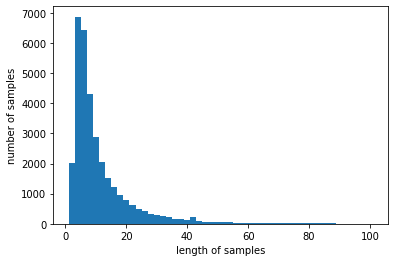

In [33]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 101이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [34]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.2656117888634


In [36]:
# 전체 훈련 데이터 중 약 94%의 리뷰가 30이하의 길이를 가지는 것을 확인
# 모든 샘플의 길이를 30으로 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [37]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
414/414 [==============================] - ETA: 0s - loss: 0.4660 - acc: 0.7967
Epoch 1: val_acc improved from -inf to 0.85900, saving model to best_model.h5
414/414 [==============================] - 45s 98ms/step - loss: 0.4660 - acc: 0.7967 - val_loss: 0.3901 - val_acc: 0.8590
Epoch 2/15
414/414 [==============================] - ETA: 0s - loss: 0.4129 - acc: 0.8355
Epoch 2: val_acc improved from 0.85900 to 0.86473, saving model to best_model.h5
414/414 [==============================] - 40s 96ms/step - loss: 0.4129 - acc: 0.8355 - val_loss: 0.3760 - val_acc: 0.8647
Epoch 3/15
414/414 [==============================] - ETA: 0s - loss: 0.4007 - acc: 0.8425
Epoch 3: val_acc did not improve from 0.86473
414/414 [==============================] - 35s 84ms/step - loss: 0.4007 - acc: 0.8425 - val_loss: 0.3760 - val_acc: 0.8629
Epoch 4/15
414/414 [==============================] - ETA: 0s - loss: 0.3909 - acc: 0.8484
Epoch 4: val_acc did not improve from 0.86473
414/414 [=======

In [38]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

306/306 [==============================] - 14s 30ms/step - loss: 0.4437 - acc: 0.8189

 테스트 정확도: 0.8189


In [39]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    return score

#   if(score > 0.5):
#     print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
#   else:
#     print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [40]:
sentiment_predict('치킨이 너무 눅눅하고 식어서 맛없어요')
sentiment_predict('치킨 맛이 그저 그래요')
sentiment_predict('배달 느려요')

0.17820504307746887

In [41]:
sentiment_predict('맛있게 잘 먹었습니다')
sentiment_predict('항상 여기서만 시켜 먹어요')
sentiment_predict('역시 믿고 먹는 치킨')

0.9263195991516113

In [42]:
import pandas as pd
df = pd.read_csv('D:/pythonTest/DataShipJo/chicken_Label_최종.csv', names=['번호','아이디','리뷰','Label'])
df.head()

,번호,아이디,리뷰,Label
0,0,pr**님,양이 많이 줄어든 느낌 이네요.,0
1,1,rh**님,혹시 hite 맥주 잘못 주신 것 아니에요? 생맥주라면 이런 맛이 안나오는데 ㅠㅠㅠ...,0
2,2,mo**님,사진 찍고싶었는데 까먹고 다 먹어버?f네용 담에 또 시킬게요!!!!,0
3,3,ky**님,냄새에 홀려 정신나간듯 먹다가 사진찍었네요ㅜㅜ 이케큰콜라가 서비스라니 번창하세요~~,0
4,4,wi**님,여긴 맛이 검증된곳이라.할말 없음,0


In [43]:
sentiment_predict(df['리뷰'][5])

0.21748188138008118

In [44]:
df = pd.read_csv('D:/pythonTest/DataShipJo/chicken_train_최종.csv', names=['업체명','총평점','주소','아이디','평점','날짜','리뷰'])
df.head()

,업체명,총평점,주소,아이디,평점,날짜,리뷰
0,BHC-시립대점,4.8,서울특별시 동대문구 전농동 295-9 성진빌딩 295-9 동광교회 1층,de**님,1,2시간 전,잘 먹었습니다
1,BHC-시립대점,4.8,서울특별시 동대문구 전농동 295-9 성진빌딩 295-9 동광교회 1층,pr**님,5,4시간 전,양이 많이 줄어든 느낌 이네요.
2,BHC-시립대점,4.8,서울특별시 동대문구 전농동 295-9 성진빌딩 295-9 동광교회 1층,sk**님,5,8시간 전,오늘도 맛나게 잘 먹었습니다~~~
3,BHC-시립대점,4.8,서울특별시 동대문구 전농동 295-9 성진빌딩 295-9 동광교회 1층,gh**님,5,10시간 전,맛있어요 양도 많아요
4,BHC-시립대점,4.8,서울특별시 동대문구 전농동 295-9 성진빌딩 295-9 동광교회 1층,ki**님,5,17시간 전,맛있게 잘먹었어요 다음에 또주문할께요


In [45]:
forScore = pd.read_csv("D:/pythonTest/DataShipJo/chicken_review_최종.csv", names=['rating','fk','date','id','review'])
forScore

,rating,fk,date,id,review
0,5,1,2022년 04월 13일,ch**,튀김옷 바삭바삭 맛있어요
1,5,1,2022년 04월 13일,gk**,배달 빠르구 맛있어용~!
2,5,1,2022년 04월 13일,gn**,맛있게 잘 먹었습니다
3,5,1,2022년 04월 13일,gf**,맛있게 잘 먹었습니다
4,5,1,2022년 04월 13일,me**,날씬한 다리가 아숩지만 맛있어요
...,...,...,...,...,...
98817,5,28,2022년 02월 15일,qa**,순삭.....ㅎㅎ 죄송합니다 넘 후딱 먹어서 사진 찍을 여유가...^^ 정말 맛있게...
98818,5,28,2022년 02월 15일,oi**,사진을 깜빡하고 먹었어요ㅠㅜ 맛은 맛있습니당
98819,5,28,2022년 02월 15일,wj**,맛도짱 서비스도 짱짱 또 시켜먹을게요~ 이벤트 많이 해주세요
98820,5,28,2022년 02월 14일,dk**,배달도 예정보다 빠르게오고 항상 맛있습니다!!


In [46]:
sentiment_predict(forScore['review'][5])

0.9255592823028564

In [47]:
score_ = pd.DataFrame({'score':[1]})

In [ ]:
cnt = 0
for i in forScore['review']:
    rating = sentiment_predict(i)
    cnt += 1
    print("번호{}:".format(cnt),  rating)
    score_ = score_.append(pd.DataFrame({'score':[rating]}))

번호1: 0.8880054950714111
번호2: 0.9140142202377319
번호3: 0.9168704152107239
번호4: 0.9168704152107239
번호5: 0.9001508355140686
번호6: 0.9255592823028564
번호7: 0.9172602295875549
번호8: 0.9142440557479858
번호9: 0.9221079349517822
번호10: 0.4495945870876312
번호11: 0.9186469316482544
번호12: 0.9328097105026245
번호13: 0.878226637840271
번호14: 0.9133642315864563
번호15: 0.9153347015380859
번호16: 0.8887824416160583
번호17: 0.9379826784133911
번호18: 0.9338992834091187
번호19: 0.914204478263855
번호20: 0.8948432207107544
번호21: 0.9330844879150391
번호22: 0.8573868274688721
번호23: 0.6271469593048096
번호24: 0.905511200428009
번호25: 0.918247640132904
번호26: 0.8770202398300171
번호27: 0.9182758331298828
번호28: 0.8964483737945557
번호29: 0.24286895990371704
번호30: 0.9226927161216736
번호31: 0.9284084439277649
번호32: 0.9163066148757935
번호33: 0.9039374589920044
번호34: 0.22724202275276184
번호35: 0.915632963180542
번호36: 0.8987452983856201
번호37: 0.9252375364303589
번호38: 0.9290941953659058
번호39: 0.30710604786872864
번호40: 0.935338020324707
번호41: 0.9166

번호321: 0.941452145576477
번호322: 0.7476551532745361
번호323: 0.9226927161216736
번호324: 0.9039374589920044
번호325: 0.7665740251541138
번호326: 0.9341559410095215
번호327: 0.9425497055053711
번호328: 0.952173113822937
번호329: 0.9176052808761597
번호330: 0.9163804054260254
번호331: 0.9224101305007935
번호332: 0.9174082279205322
번호333: 0.9313491582870483
번호334: 0.8867138028144836
번호335: 0.10406041145324707
번호336: 0.25545889139175415
번호337: 0.8859376907348633
번호338: 0.9182087182998657
번호339: 0.9115766286849976
번호340: 0.5419109463691711
번호341: 0.8944306969642639
번호342: 0.9168704152107239
번호343: 0.898975133895874
번호344: 0.6948733925819397
번호345: 0.3060118854045868
번호346: 0.3060118854045868
번호347: 0.9362286329269409
번호348: 0.9269401431083679
번호349: 0.6648964881896973
번호350: 0.9168704152107239
번호351: 0.9070336818695068
번호352: 0.8389995098114014
번호353: 0.9160475730895996
번호354: 0.9168704152107239
번호355: 0.9168704152107239
번호356: 0.9250072240829468
번호357: 0.9325224757194519
번호358: 0.20704561471939087
번호359: 0.892

번호638: 0.9168704152107239
번호639: 0.9413467049598694
번호640: 0.9202035665512085
번호641: 0.9445793628692627
번호642: 0.9224488735198975
번호643: 0.9226927161216736
번호644: 0.9358066320419312
번호645: 0.9256657361984253
번호646: 0.9168704152107239
번호647: 0.8766405582427979
번호648: 0.8936066627502441
번호649: 0.9294530153274536
번호650: 0.14766767621040344
번호651: 0.9168704152107239
번호652: 0.9320046901702881
번호653: 0.18922114372253418
번호654: 0.2930564880371094
번호655: 0.9193060994148254
번호656: 0.9462794065475464
번호657: 0.935754656791687
번호658: 0.9248781800270081
번호659: 0.2905924320220947
번호660: 0.5910344123840332
번호661: 0.8766900897026062
번호662: 0.18336769938468933
번호663: 0.9042609333992004
번호664: 0.7414805293083191
번호665: 0.2411845624446869
번호666: 0.1583573818206787
번호667: 0.914902925491333
번호668: 0.9041948318481445
번호669: 0.6767680644989014
번호670: 0.9238265752792358
번호671: 0.26757389307022095
번호672: 0.9053551554679871
번호673: 0.9086644053459167
번호674: 0.3257210850715637
번호675: 0.8850144147872925
번호676: 0.9

번호954: 0.9107733964920044
번호955: 0.8834691643714905
번호956: 0.23067975044250488
번호957: 0.8932236433029175
번호958: 0.8882239460945129
번호959: 0.923122227191925
번호960: 0.2825799286365509
번호961: 0.9482367038726807
번호962: 0.9295018911361694
번호963: 0.9140142202377319
번호964: 0.9152944087982178
번호965: 0.9417371153831482
번호966: 0.8105283975601196
번호967: 0.9226927161216736
번호968: 0.9226927161216736
번호969: 0.6077439188957214
번호970: 0.8943846225738525
번호971: 0.901813268661499
번호972: 0.9220247864723206
번호973: 0.9168704152107239
번호974: 0.9136180877685547
번호975: 0.9053388833999634
번호976: 0.4495945870876312
번호977: 0.8955044746398926
번호978: 0.8958296775817871
번호979: 0.9406640529632568
번호980: 0.9226927161216736
번호981: 0.9226927161216736
번호982: 0.8300725221633911
번호983: 0.9403972625732422
번호984: 0.9049883484840393
번호985: 0.9168704152107239
번호986: 0.9271103739738464
번호987: 0.9253906607627869
번호988: 0.6818614602088928
번호989: 0.9226927161216736
번호990: 0.9226927161216736
번호991: 0.8978354930877686
번호992: 0.8789

번호1260: 0.7806217670440674
번호1261: 0.2815930247306824
번호1262: 0.906018853187561
번호1263: 0.9179224967956543
번호1264: 0.9272666573524475
번호1265: 0.9073851108551025
번호1266: 0.9039374589920044
번호1267: 0.9136927723884583
번호1268: 0.34049510955810547
번호1269: 0.9477531909942627
번호1270: 0.9259306192398071
번호1271: 0.9143980741500854
번호1272: 0.9277846813201904
번호1273: 0.9129703640937805
번호1274: 0.9168704152107239
번호1275: 0.12787747383117676
번호1276: 0.9324232339859009
번호1277: 0.9165584444999695
번호1278: 0.9229317307472229
번호1279: 0.9080178737640381
번호1280: 0.9182087182998657
번호1281: 0.26757389307022095
번호1282: 0.8686414957046509
번호1283: 0.9269839525222778
번호1284: 0.9120162129402161
번호1285: 0.9360060691833496
번호1286: 0.9226927161216736
번호1287: 0.9013742208480835
번호1288: 0.9039374589920044
번호1289: 0.9225545525550842
번호1290: 0.918360710144043
번호1291: 0.19047459959983826
번호1292: 0.9320491552352905
번호1293: 0.9413620829582214
번호1294: 0.9233412742614746
번호1295: 0.9274905920028687
번호1296: 0.9287409782409668

번호1564: 0.9343115091323853
번호1565: 0.9115424156188965
번호1566: 0.9160727262496948
번호1567: 0.9278545379638672
번호1568: 0.8740957975387573
번호1569: 0.898597240447998
번호1570: 0.5461609363555908
번호1571: 0.9200379252433777
번호1572: 0.9168704152107239
번호1573: 0.9008072018623352
번호1574: 0.9140142202377319
번호1575: 0.8699073791503906
번호1576: 0.9226927161216736
번호1577: 0.9346798658370972
번호1578: 0.9205402135848999
번호1579: 0.9226927161216736
번호1580: 0.9015337228775024
번호1581: 0.8972078561782837
번호1582: 0.9118091464042664
번호1583: 0.40770071744918823
번호1584: 0.9039374589920044
번호1585: 0.9062914252281189
번호1586: 0.14519760012626648
번호1587: 0.8794499635696411
번호1588: 0.9000461101531982
번호1589: 0.9158384799957275
번호1590: 0.9200379252433777
번호1591: 0.18073245882987976
번호1592: 0.931584358215332
번호1593: 0.9168704152107239
번호1594: 0.9039374589920044
번호1595: 0.9399698972702026
번호1596: 0.9175351858139038
번호1597: 0.9168704152107239
번호1598: 0.14244747161865234
번호1599: 0.9172911643981934
번호1600: 0.7535489797592163

번호1870: 0.6350997686386108
번호1871: 0.9259913563728333
번호1872: 0.9120285511016846
번호1873: 0.9011638164520264
번호1874: 0.9013727307319641
번호1875: 0.9139606952667236
번호1876: 0.5994677543640137
번호1877: 0.9168704152107239
번호1878: 0.9109378457069397
번호1879: 0.9168704152107239
번호1880: 0.9151661992073059
번호1881: 0.9205479621887207
번호1882: 0.41820889711380005
번호1883: 0.9226786494255066
번호1884: 0.9432259202003479
번호1885: 0.9186718463897705
번호1886: 0.9400894045829773
번호1887: 0.8965291976928711
번호1888: 0.9139143824577332
번호1889: 0.9208183288574219
번호1890: 0.9341527223587036
번호1891: 0.9062308073043823
번호1892: 0.9420115351676941
번호1893: 0.12980327010154724
번호1894: 0.9359649419784546
번호1895: 0.9039374589920044
번호1896: 0.9175266027450562
번호1897: 0.9168704152107239
번호1898: 0.9325090646743774
번호1899: 0.9226927161216736
번호1900: 0.9304533004760742
번호1901: 0.8905614614486694
번호1902: 0.9082666039466858
번호1903: 0.9322420358657837
번호1904: 0.9294530153274536
번호1905: 0.906549334526062
번호1906: 0.933809220790863
번

번호2174: 0.9226927161216736
번호2175: 0.9273094534873962
번호2176: 0.9168704152107239
번호2177: 0.8910864591598511
번호2178: 0.9226927161216736
번호2179: 0.9168707132339478
번호2180: 0.908383309841156
번호2181: 0.9226927161216736
번호2182: 0.9388012290000916
번호2183: 0.827796220779419
번호2184: 0.8878802061080933
번호2185: 0.9438940286636353
번호2186: 0.24634182453155518
번호2187: 0.9210033416748047
번호2188: 0.9104747772216797
번호2189: 0.9112998843193054
번호2190: 0.9010269641876221
번호2191: 0.8899257779121399
번호2192: 0.8717831373214722
번호2193: 0.91298508644104
번호2194: 0.8996032476425171
번호2195: 0.8804587125778198
번호2196: 0.21796053647994995
번호2197: 0.8822375535964966
번호2198: 0.18053635954856873
번호2199: 0.17788922786712646
번호2200: 0.2745891809463501
번호2201: 0.7971413731575012
번호2202: 0.925067663192749
번호2203: 0.9212912321090698
번호2204: 0.9352150559425354
번호2205: 0.9300287961959839
번호2206: 0.9425243735313416
번호2207: 0.9295450448989868
번호2208: 0.8988305926322937
번호2209: 0.938409686088562
번호2210: 0.9035588502883911
번호2

번호2479: 0.673660933971405
번호2480: 0.9010329246520996
번호2481: 0.937679648399353
번호2482: 0.9076316952705383
번호2483: 0.47480279207229614
번호2484: 0.9344150424003601
번호2485: 0.925331711769104
번호2486: 0.9397763013839722
번호2487: 0.8983139991760254
번호2488: 0.9425240159034729
번호2489: 0.9205570220947266
번호2490: 0.8781802654266357
번호2491: 0.9442410469055176
번호2492: 0.9061850309371948
번호2493: 0.9168704152107239
번호2494: 0.9039374589920044
번호2495: 0.9034081697463989
번호2496: 0.9235196113586426
번호2497: 0.9287731647491455
번호2498: 0.9013525247573853
번호2499: 0.9057190418243408
번호2500: 0.9226927161216736
번호2501: 0.9209377765655518
번호2502: 0.9313701391220093
번호2503: 0.9232227802276611
번호2504: 0.9109203815460205
번호2505: 0.9242478609085083
번호2506: 0.1990509331226349
번호2507: 0.37257665395736694
번호2508: 0.909245491027832
번호2509: 0.9116536378860474
번호2510: 0.8578783273696899
번호2511: 0.9136782884597778
번호2512: 0.8915808796882629
번호2513: 0.9139994382858276
번호2514: 0.7897541522979736
번호2515: 0.6820764541625977
번호2

번호2784: 0.8453220129013062
번호2785: 0.8892505168914795
번호2786: 0.9297024011611938
번호2787: 0.7127028703689575
번호2788: 0.9021656513214111
번호2789: 0.8875342011451721
번호2790: 0.8807456493377686
번호2791: 0.9159891605377197
번호2792: 0.9226927161216736
번호2793: 0.9039374589920044
번호2794: 0.8894951343536377
번호2795: 0.9354780912399292
번호2796: 0.9381126165390015
번호2797: 0.9270369410514832
번호2798: 0.9504432678222656
번호2799: 0.9425661563873291
번호2800: 0.9293415546417236
번호2801: 0.8941947221755981
번호2802: 0.9295709133148193
번호2803: 0.46114304661750793
번호2804: 0.9248011708259583
번호2805: 0.2552953362464905
번호2806: 0.9074557423591614
번호2807: 0.9168704152107239
번호2808: 0.9455804228782654
번호2809: 0.9052156209945679
번호2810: 0.6707187294960022
번호2811: 0.9227956533432007
번호2812: 0.3359852731227875
번호2813: 0.7211604118347168
번호2814: 0.6870435476303101
번호2815: 0.9226927161216736
번호2816: 0.9226927161216736
번호2817: 0.900741696357727
번호2818: 0.2522536814212799
번호2819: 0.30916982889175415
번호2820: 0.932499885559082
번

번호3090: 0.1429276168346405
번호3091: 0.929611325263977
번호3092: 0.9008015394210815
번호3093: 0.9005139470100403
번호3094: 0.9201294183731079
번호3095: 0.9381633400917053
번호3096: 0.8471654653549194
번호3097: 0.26757389307022095
번호3098: 0.941015362739563
번호3099: 0.8933572769165039
번호3100: 0.9209433794021606
번호3101: 0.9323134422302246
번호3102: 0.904718279838562
번호3103: 0.9140142202377319
번호3104: 0.9025869369506836
번호3105: 0.9383559226989746
번호3106: 0.9157119989395142
번호3107: 0.39996227622032166
번호3108: 0.9194031953811646
번호3109: 0.9108082056045532
번호3110: 0.8840335011482239
번호3111: 0.9319705963134766
번호3112: 0.91359543800354
번호3113: 0.9216002821922302
번호3114: 0.9063551425933838
번호3115: 0.9152365922927856
번호3116: 0.917625904083252
번호3117: 0.9378517866134644
번호3118: 0.18354424834251404
번호3119: 0.9174082279205322
번호3120: 0.9036421775817871
번호3121: 0.19911938905715942
번호3122: 0.9118853211402893
번호3123: 0.9152512550354004
번호3124: 0.9173272848129272
번호3125: 0.9259155988693237
번호3126: 0.15396031737327576
번호

번호3394: 0.9358928203582764
번호3395: 0.6014161705970764
번호3396: 0.9263637065887451
번호3397: 0.9130542278289795
번호3398: 0.9221491813659668
번호3399: 0.9039374589920044
번호3400: 0.9176958799362183
번호3401: 0.9168704152107239
번호3402: 0.9427405595779419
번호3403: 0.9363061189651489
번호3404: 0.9226927161216736
번호3405: 0.9200697541236877
번호3406: 0.9256026148796082
번호3407: 0.8671197891235352
번호3408: 0.9083875417709351
번호3409: 0.9140142202377319
번호3410: 0.9226927161216736
번호3411: 0.9111891388893127
번호3412: 0.9168704152107239
번호3413: 0.5499709844589233
번호3414: 0.9274195432662964
번호3415: 0.9226927161216736
번호3416: 0.8984248638153076
번호3417: 0.9345148801803589
번호3418: 0.2189922332763672
번호3419: 0.9144057631492615
번호3420: 0.9180152416229248
번호3421: 0.22934287786483765
번호3422: 0.9175351858139038
번호3423: 0.9039374589920044
번호3424: 0.9012734889984131
번호3425: 0.9286598563194275
번호3426: 0.916107714176178
번호3427: 0.9383293390274048
번호3428: 0.9253360033035278
번호3429: 0.9304686784744263
번호3430: 0.8941757678985596
번

번호3699: 0.8893696069717407
번호3700: 0.21075856685638428
번호3701: 0.17326068878173828
번호3702: 0.9003353118896484
번호3703: 0.8677424192428589
번호3704: 0.8945232629776001
번호3705: 0.9416675567626953
번호3706: 0.9333575963973999
번호3707: 0.9409477710723877
번호3708: 0.9174082279205322
번호3709: 0.9259468913078308
번호3710: 0.9168704152107239
번호3711: 0.39480388164520264
번호3712: 0.9222878217697144
번호3713: 0.9124530553817749
번호3714: 0.12837138772010803
번호3715: 0.1517806351184845
번호3716: 0.7446498870849609
번호3717: 0.9181020259857178
번호3718: 0.29610684514045715
번호3719: 0.22373265027999878
번호3720: 0.8847528696060181
번호3721: 0.931797206401825
번호3722: 0.9134531617164612
번호3723: 0.9318375587463379
번호3724: 0.94554603099823
번호3725: 0.9226927161216736
번호3726: 0.816669225692749
번호3727: 0.16906598210334778
번호3728: 0.9480891227722168
번호3729: 0.9143831729888916
번호3730: 0.9202637076377869
번호3731: 0.9039374589920044
번호3732: 0.9133371114730835
번호3733: 0.9462459683418274
번호3734: 0.9257808923721313
번호3735: 0.890468060970306

번호4003: 0.548896849155426
번호4004: 0.9146038889884949
번호4005: 0.9140142202377319
번호4006: 0.18261930346488953
번호4007: 0.9190401434898376
번호4008: 0.3326421082019806
번호4009: 0.9168704152107239
번호4010: 0.9039374589920044
번호4011: 0.9033203125
번호4012: 0.3038145899772644
번호4013: 0.9277372360229492
번호4014: 0.856359601020813
번호4015: 0.6519366502761841
번호4016: 0.9163312911987305
번호4017: 0.8939434289932251
번호4018: 0.918506383895874
번호4019: 0.8370152711868286
번호4020: 0.9399253129959106
번호4021: 0.9107167720794678
번호4022: 0.8400781154632568
번호4023: 0.6871320009231567
번호4024: 0.9226927161216736
번호4025: 0.9322936534881592
번호4026: 0.24566227197647095
번호4027: 0.9301747679710388
번호4028: 0.9168704152107239
번호4029: 0.9119222164154053
번호4030: 0.9068171977996826
번호4031: 0.9216952919960022
번호4032: 0.9212249517440796
번호4033: 0.34338417649269104
번호4034: 0.9170629978179932
번호4035: 0.8951558470726013
번호4036: 0.9315626621246338
번호4037: 0.5007704496383667
번호4038: 0.9317843914031982
번호4039: 0.9002530574798584
번호4040:

번호4308: 0.9091964960098267
번호4309: 0.939109206199646
번호4310: 0.9491919279098511
번호4311: 0.9386149644851685
번호4312: 0.9090298414230347
번호4313: 0.5930723547935486
번호4314: 0.9376736283302307
번호4315: 0.9258805513381958
번호4316: 0.9338315725326538
번호4317: 0.9132636785507202
번호4318: 0.9226927161216736
번호4319: 0.8807114362716675
번호4320: 0.9019887447357178
번호4321: 0.9322951436042786
번호4322: 0.9229689240455627
번호4323: 0.9290767908096313
번호4324: 0.17210909724235535
번호4325: 0.9386545419692993
번호4326: 0.28405359387397766
번호4327: 0.9047731161117554
번호4328: 0.9216002821922302
번호4329: 0.9119222164154053
번호4330: 0.84751296043396
번호4331: 0.26757389307022095
번호4332: 0.5741464495658875
번호4333: 0.9270920753479004
번호4334: 0.9313868284225464
번호4335: 0.9174031019210815
번호4336: 0.7343153357505798
번호4337: 0.9309083223342896
번호4338: 0.9410789012908936
번호4339: 0.8686394691467285
번호4340: 0.9283972382545471
번호4341: 0.8892996311187744
번호4342: 0.8542897701263428
번호4343: 0.9370912909507751
번호4344: 0.9287732243537903
번

번호4612: 0.8980361223220825
번호4613: 0.923038125038147
번호4614: 0.9061964750289917
번호4615: 0.9047143459320068
번호4616: 0.9168704152107239
번호4617: 0.9236389398574829
번호4618: 0.9148252606391907
번호4619: 0.9236346483230591
번호4620: 0.9039374589920044
번호4621: 0.9132704734802246
번호4622: 0.19888624548912048
번호4623: 0.9408528804779053
번호4624: 0.9438589811325073
번호4625: 0.9344421625137329
번호4626: 0.9340522289276123
번호4627: 0.9125891923904419
번호4628: 0.8989810943603516
번호4629: 0.9332064390182495
번호4630: 0.9352104663848877
번호4631: 0.9285036325454712
번호4632: 0.908614993095398
번호4633: 0.9170712232589722
번호4634: 0.9338998794555664
번호4635: 0.9401907920837402
번호4636: 0.9243120551109314
번호4637: 0.9392757415771484
번호4638: 0.9233243465423584
번호4639: 0.9039374589920044
번호4640: 0.9274193644523621
번호4641: 0.11993905901908875
번호4642: 0.786518394947052
번호4643: 0.9226927161216736
번호4644: 0.9168704152107239
번호4645: 0.26757389307022095
번호4646: 0.6644855737686157
번호4647: 0.9168704152107239
번호4648: 0.9175187945365906
번

번호4916: 0.9520441889762878
번호4917: 0.9136762619018555
번호4918: 0.9210312366485596
번호4919: 0.39049476385116577
번호4920: 0.207433819770813
번호4921: 0.947253942489624
번호4922: 0.2354511320590973
번호4923: 0.9351823925971985
번호4924: 0.9140142202377319
번호4925: 0.9049883484840393
번호4926: 0.9413127303123474
번호4927: 0.14285311102867126
번호4928: 0.27239492535591125
번호4929: 0.9246360063552856
번호4930: 0.9333478212356567
번호4931: 0.9288290739059448
번호4932: 0.617293119430542
번호4933: 0.9416955709457397
번호4934: 0.9176425337791443
번호4935: 0.9193876385688782
번호4936: 0.889173150062561
번호4937: 0.932426393032074
번호4938: 0.9376523494720459
번호4939: 0.9229756593704224
번호4940: 0.9414751529693604
번호4941: 0.7192459106445312
번호4942: 0.9023939371109009
번호4943: 0.9336999654769897
번호4944: 0.949709951877594
번호4945: 0.8427877426147461
번호4946: 0.9226927161216736
번호4947: 0.2210811972618103
번호4948: 0.37986212968826294
번호4949: 0.9245002269744873
번호4950: 0.9283406734466553
번호4951: 0.9424684643745422
번호4952: 0.9039374589920044
번호4

번호5220: 0.9147814512252808
번호5221: 0.9083486795425415
번호5222: 0.9435954093933105
번호5223: 0.8912394046783447
번호5224: 0.9304537773132324
번호5225: 0.9159660935401917
번호5226: 0.6834530830383301
번호5227: 0.7959035634994507
번호5228: 0.9082955121994019
번호5229: 0.9030768871307373
번호5230: 0.9081979990005493
번호5231: 0.9149593114852905
번호5232: 0.8990297913551331
번호5233: 0.9146066904067993
번호5234: 0.9098107218742371
번호5235: 0.3599635064601898
번호5236: 0.21975216269493103
번호5237: 0.9200571179389954
번호5238: 0.9011471271514893
번호5239: 0.910709023475647
번호5240: 0.9329814910888672
번호5241: 0.9164420366287231
번호5242: 0.9010329246520996
번호5243: 0.9277596473693848
번호5244: 0.9270879030227661
번호5245: 0.9226927161216736
번호5246: 0.9244953989982605
번호5247: 0.6656295657157898
번호5248: 0.9391546249389648
번호5249: 0.8861925601959229
번호5250: 0.4147053062915802
번호5251: 0.8942081332206726
번호5252: 0.9382873773574829
번호5253: 0.9201624989509583
번호5254: 0.9208487272262573
번호5255: 0.9168704152107239
번호5256: 0.9049883484840393
번

번호5525: 0.9211541414260864
번호5526: 0.9226927161216736
번호5527: 0.8865000009536743
번호5528: 0.9226927161216736
번호5529: 0.9224299788475037
번호5530: 0.23554480075836182
번호5531: 0.9318853616714478
번호5532: 0.9272564649581909
번호5533: 0.9298079013824463
번호5534: 0.9143539667129517
번호5535: 0.9340816736221313
번호5536: 0.9168704152107239
번호5537: 0.4736219346523285
번호5538: 0.9096101522445679
번호5539: 0.9182807803153992
번호5540: 0.9179340600967407
번호5541: 0.9323893785476685
번호5542: 0.9134531617164612
번호5543: 0.9377517104148865
번호5544: 0.9359750747680664
번호5545: 0.9393373727798462
번호5546: 0.9175351858139038
번호5547: 0.9180152416229248
번호5548: 0.2777614891529083
번호5549: 0.5566675662994385
번호5550: 0.9013742208480835
번호5551: 0.9305957555770874
번호5552: 0.904964804649353
번호5553: 0.9083189964294434
번호5554: 0.9084880352020264
번호5555: 0.9010329246520996
번호5556: 0.9373756647109985
번호5557: 0.5044000744819641
번호5558: 0.9207561016082764
번호5559: 0.9081363677978516
번호5560: 0.9171127080917358
번호5561: 0.14277294278144836


번호5829: 0.9058043956756592
번호5830: 0.1803634762763977
번호5831: 0.9070308208465576
번호5832: 0.9171647429466248
번호5833: 0.17679104208946228
번호5834: 0.94172203540802
번호5835: 0.9169082641601562
번호5836: 0.947991669178009
번호5837: 0.9039973020553589
번호5838: 0.9252948760986328
번호5839: 0.9039236307144165
번호5840: 0.9211600422859192
번호5841: 0.9144339561462402
번호5842: 0.2893829047679901
번호5843: 0.9257131814956665
번호5844: 0.8930933475494385
번호5845: 0.18841755390167236
번호5846: 0.9316369891166687
번호5847: 0.9368621110916138
번호5848: 0.634650468826294
번호5849: 0.93280029296875
번호5850: 0.8984586000442505
번호5851: 0.9307223558425903
번호5852: 0.7085933685302734
번호5853: 0.9267752170562744
번호5854: 0.4495945870876312
번호5855: 0.9168704152107239
번호5856: 0.9374973773956299
번호5857: 0.8985758423805237
번호5858: 0.9208719730377197
번호5859: 0.9039374589920044
번호5860: 0.925771951675415
번호5861: 0.9111423492431641
번호5862: 0.904881477355957
번호5863: 0.9226927161216736
번호5864: 0.8980176448822021
번호5865: 0.8727505207061768
번호5866:

번호6134: 0.9246953129768372
번호6135: 0.9079887270927429
번호6136: 0.673431932926178
번호6137: 0.9100775122642517
번호6138: 0.14631512761116028
번호6139: 0.949217677116394
번호6140: 0.9195787310600281
번호6141: 0.6990659236907959
번호6142: 0.9264519214630127
번호6143: 0.4932727515697479
번호6144: 0.7948486804962158
번호6145: 0.16051948070526123
번호6146: 0.15772080421447754
번호6147: 0.9396859407424927
번호6148: 0.9141930341720581
번호6149: 0.9073851108551025
번호6150: 0.176118403673172
번호6151: 0.9190199375152588
번호6152: 0.7661622762680054
번호6153: 0.9228487014770508
번호6154: 0.928864598274231
번호6155: 0.9229639768600464
번호6156: 0.9261053204536438
번호6157: 0.9315764904022217
번호6158: 0.9341716766357422
번호6159: 0.9415441751480103
번호6160: 0.9033334255218506
번호6161: 0.30655109882354736
번호6162: 0.9122707843780518
번호6163: 0.9063977003097534
번호6164: 0.30145367980003357
번호6165: 0.9083476066589355
번호6166: 0.9135817289352417
번호6167: 0.8815879821777344
번호6168: 0.885193943977356
번호6169: 0.8929375410079956
번호6170: 0.8056194186210632
번

번호6439: 0.9337053298950195
번호6440: 0.48191261291503906
번호6441: 0.9168704152107239
번호6442: 0.9008072018623352
번호6443: 0.9214349389076233
번호6444: 0.9420254230499268
번호6445: 0.9404391050338745
번호6446: 0.9385143518447876
번호6447: 0.9079821109771729
번호6448: 0.9014110565185547
번호6449: 0.9174082279205322
번호6450: 0.30380451679229736
번호6451: 0.8046172857284546
번호6452: 0.905166506767273
번호6453: 0.9103443622589111
번호6454: 0.9138990640640259
번호6455: 0.9181183576583862
번호6456: 0.8540554046630859
번호6457: 0.9078465700149536
번호6458: 0.9039374589920044
번호6459: 0.9406089186668396
번호6460: 0.12846994400024414
번호6461: 0.9051163196563721
번호6462: 0.8823302984237671
번호6463: 0.9309494495391846
번호6464: 0.9254789352416992
번호6465: 0.9146258234977722
번호6466: 0.8863834738731384
번호6467: 0.9382104873657227
번호6468: 0.9264016151428223
번호6469: 0.9418121576309204
번호6470: 0.17433738708496094
번호6471: 0.16607317328453064
번호6472: 0.34900927543640137
번호6473: 0.9068104028701782
번호6474: 0.9201294183731079
번호6475: 0.9126279354095

번호6744: 0.9168704152107239
번호6745: 0.9140142202377319
번호6746: 0.922613263130188
번호6747: 0.8709214925765991
번호6748: 0.9453436136245728
번호6749: 0.896938681602478
번호6750: 0.9224159121513367
번호6751: 0.914677619934082
번호6752: 0.9175698757171631
번호6753: 0.9387800693511963
번호6754: 0.9156702160835266
번호6755: 0.9406733512878418
번호6756: 0.2066502869129181
번호6757: 0.9410108327865601
번호6758: 0.8692933320999146
번호6759: 0.9185013771057129
번호6760: 0.936623215675354
번호6761: 0.859764814376831
번호6762: 0.7537051439285278
번호6763: 0.8993996381759644
번호6764: 0.926746129989624
번호6765: 0.9143717288970947
번호6766: 0.8846408128738403
번호6767: 0.9049883484840393
번호6768: 0.9378272891044617
번호6769: 0.9385174512863159
번호6770: 0.9254581928253174
번호6771: 0.9253906607627869
번호6772: 0.8423749208450317
번호6773: 0.9304022789001465
번호6774: 0.924948513507843
번호6775: 0.928219199180603
번호6776: 0.9333348274230957
번호6777: 0.8986096382141113
번호6778: 0.4690690338611603
번호6779: 0.14669299125671387
번호6780: 0.9349167943000793
번호6781: 

번호7050: 0.8920649886131287
번호7051: 0.7499624490737915
번호7052: 0.9140142202377319
번호7053: 0.9180152416229248
번호7054: 0.9182087182998657
번호7055: 0.9297621250152588
번호7056: 0.9226927161216736
번호7057: 0.9266675114631653
번호7058: 0.9193137884140015
번호7059: 0.9027203321456909
번호7060: 0.9408422112464905
번호7061: 0.920064389705658
번호7062: 0.4731077551841736
번호7063: 0.9142137765884399
번호7064: 0.9192901849746704
번호7065: 0.918053150177002
번호7066: 0.9321043491363525
번호7067: 0.9065235257148743
번호7068: 0.9253329038619995
번호7069: 0.9401848316192627
번호7070: 0.9121593236923218
번호7071: 0.12874296307563782
번호7072: 0.9143240451812744
번호7073: 0.9025628566741943
번호7074: 0.7832561731338501
번호7075: 0.16259393095970154
번호7076: 0.9081965684890747
번호7077: 0.39042598009109497
번호7078: 0.9444456100463867
번호7079: 0.9336491823196411
번호7080: 0.8785700798034668
번호7081: 0.8963683843612671
번호7082: 0.9117839932441711
번호7083: 0.9226927161216736
번호7084: 0.526568591594696
번호7085: 0.6912753582000732
번호7086: 0.9301718473434448
번

번호7354: 0.8994361162185669
번호7355: 0.9328393936157227
번호7356: 0.1586754024028778
번호7357: 0.6426848769187927
번호7358: 0.17895492911338806
번호7359: 0.9054830074310303
번호7360: 0.9187935590744019
번호7361: 0.936625599861145
번호7362: 0.7392861843109131
번호7363: 0.9070349931716919
번호7364: 0.9218541383743286
번호7365: 0.945071280002594
번호7366: 0.9168704152107239
번호7367: 0.9263633489608765
번호7368: 0.26473522186279297
번호7369: 0.9249420166015625
번호7370: 0.9207299947738647
번호7371: 0.9122707843780518
번호7372: 0.9047653675079346
번호7373: 0.9341243505477905
번호7374: 0.9027203321456909
번호7375: 0.9175187945365906
번호7376: 0.6188874244689941
번호7377: 0.9228896498680115
번호7378: 0.5312759876251221
번호7379: 0.9065011739730835
번호7380: 0.906417965888977
번호7381: 0.9150872230529785
번호7382: 0.9226927161216736
번호7383: 0.418337345123291
번호7384: 0.9349988698959351
번호7385: 0.9180152416229248
번호7386: 0.9376025199890137
번호7387: 0.21167320013046265
번호7388: 0.875588595867157
번호7389: 0.9430286288261414
번호7390: 0.9364157915115356
번호7

번호7658: 0.9112215638160706
번호7659: 0.9191901683807373
번호7660: 0.936966061592102
번호7661: 0.9190982580184937
번호7662: 0.12506327033042908
번호7663: 0.9225199222564697
번호7664: 0.9382401704788208
번호7665: 0.9217936992645264
번호7666: 0.9236384034156799
번호7667: 0.9405527114868164
번호7668: 0.3053896427154541
번호7669: 0.9347164630889893
번호7670: 0.859764814376831
번호7671: 0.8870737552642822
번호7672: 0.15496623516082764
번호7673: 0.9027203321456909
번호7674: 0.18313199281692505
번호7675: 0.920170783996582
번호7676: 0.9301486611366272
번호7677: 0.8979635238647461
번호7678: 0.7810409069061279
번호7679: 0.9049883484840393
번호7680: 0.9039236307144165
번호7681: 0.9268732666969299
번호7682: 0.9403898119926453
번호7683: 0.9439826011657715
번호7684: 0.2055995762348175
번호7685: 0.3280211389064789
번호7686: 0.9253886342048645
번호7687: 0.9354310035705566
번호7688: 0.9108356833457947
번호7689: 0.9279296398162842
번호7690: 0.6938779354095459
번호7691: 0.914518415927887
번호7692: 0.885279655456543
번호7693: 0.6989209651947021
번호7694: 0.9154741168022156
번호7

번호7962: 0.8100582361221313
번호7963: 0.25994107127189636
번호7964: 0.3474176526069641
번호7965: 0.31728827953338623
번호7966: 0.2605701684951782
번호7967: 0.9168704152107239
번호7968: 0.3582049608230591
번호7969: 0.9244622588157654
번호7970: 0.9173310995101929
번호7971: 0.9188221096992493
번호7972: 0.9144517183303833
번호7973: 0.9216002821922302
번호7974: 0.9403696060180664
번호7975: 0.1508525311946869
번호7976: 0.9198421239852905
번호7977: 0.9109378457069397
번호7978: 0.9041163921356201
번호7979: 0.9039374589920044
번호7980: 0.33613795042037964
번호7981: 0.9309321641921997
번호7982: 0.9201294183731079
번호7983: 0.8914259076118469
번호7984: 0.9373770952224731
번호7985: 0.2131463885307312
번호7986: 0.9039374589920044
번호7987: 0.9328387975692749
번호7988: 0.9425643086433411
번호7989: 0.5254292488098145
번호7990: 0.20709311962127686
번호7991: 0.12831544876098633
번호7992: 0.41050830483436584
번호7993: 0.9315207600593567
번호7994: 0.915215253829956
번호7995: 0.9368666410446167
번호7996: 0.911894679069519
번호7997: 0.9293766617774963
번호7998: 0.93072092533111

번호8266: 0.27104151248931885
번호8267: 0.9363111257553101
번호8268: 0.1537192463874817
번호8269: 0.2098093032836914
번호8270: 0.8458899855613708
번호8271: 0.90464186668396
번호8272: 0.8778505325317383
번호8273: 0.28435367345809937
번호8274: 0.9260279536247253
번호8275: 0.8650436401367188
번호8276: 0.8798501491546631
번호8277: 0.4752976596355438
번호8278: 0.26757389307022095
번호8279: 0.9154045581817627
번호8280: 0.9168704152107239
번호8281: 0.3537518382072449
번호8282: 0.9182087182998657
번호8283: 0.9014044404029846
번호8284: 0.12460100650787354
번호8285: 0.1519278883934021
번호8286: 0.1839768886566162
번호8287: 0.8934969305992126
번호8288: 0.2653640806674957
번호8289: 0.8961778879165649
번호8290: 0.8844380378723145
번호8291: 0.9182087182998657
번호8292: 0.9180152416229248
번호8293: 0.8606240749359131
번호8294: 0.9190396070480347
번호8295: 0.936577558517456
번호8296: 0.8913904428482056
번호8297: 0.9245785474777222
번호8298: 0.9168704152107239
번호8299: 0.9251960515975952
번호8300: 0.9216986298561096
번호8301: 0.9009228348731995
번호8302: 0.4495945870876312


번호8571: 0.8624032139778137
번호8572: 0.9182087182998657
번호8573: 0.9168704152107239
번호8574: 0.945228099822998
번호8575: 0.9039374589920044
번호8576: 0.9202226996421814
번호8577: 0.9015731811523438
번호8578: 0.21623671054840088
번호8579: 0.8918668031692505
번호8580: 0.9174104928970337
번호8581: 0.8214199542999268
번호8582: 0.2285519242286682
번호8583: 0.9297986030578613
번호8584: 0.9253993034362793
번호8585: 0.38966184854507446
번호8586: 0.8850395083427429
번호8587: 0.9232009649276733
번호8588: 0.9271574020385742
번호8589: 0.8968701958656311
번호8590: 0.9223529100418091
번호8591: 0.9200379252433777
번호8592: 0.9168704152107239
번호8593: 0.22768107056617737
번호8594: 0.9122707843780518
번호8595: 0.7388243079185486
번호8596: 0.7995157837867737
번호8597: 0.8264211416244507
번호8598: 0.855527937412262
번호8599: 0.4495945870876312
번호8600: 0.8942569494247437
번호8601: 0.9375344514846802
번호8602: 0.8997569680213928
번호8603: 0.9274628162384033
번호8604: 0.6819643974304199
번호8605: 0.9417479038238525
번호8606: 0.9084011912345886
번호8607: 0.20628398656845093

번호8876: 0.24449068307876587
번호8877: 0.9260112047195435
번호8878: 0.8868523836135864
번호8879: 0.912068247795105
번호8880: 0.9147078990936279
번호8881: 0.14351388812065125
번호8882: 0.26757389307022095
번호8883: 0.6602286100387573
번호8884: 0.8971253633499146
번호8885: 0.8968141078948975
번호8886: 0.9351280927658081
번호8887: 0.8992352485656738
번호8888: 0.9124845266342163
번호8889: 0.9214426279067993
번호8890: 0.948177695274353
번호8891: 0.9267845153808594
번호8892: 0.9142799377441406
번호8893: 0.9158462285995483
번호8894: 0.9181492328643799
번호8895: 0.9454914331436157
번호8896: 0.9285165071487427
번호8897: 0.7202169299125671
번호8898: 0.8848092555999756
번호8899: 0.9149794578552246
번호8900: 0.9305310249328613
번호8901: 0.9168704152107239
번호8902: 0.899060070514679
번호8903: 0.8768101930618286
번호8904: 0.8262515664100647
번호8905: 0.28406497836112976
번호8906: 0.9143226146697998
번호8907: 0.9256742000579834
번호8908: 0.9240262508392334
번호8909: 0.8869386911392212
번호8910: 0.44650033116340637
번호8911: 0.4726691246032715
번호8912: 0.9426534175872803

번호9180: 0.8296847343444824
번호9181: 0.8896998167037964
번호9182: 0.9276266694068909
번호9183: 0.774011492729187
번호9184: 0.9314389228820801
번호9185: 0.124396413564682
번호9186: 0.9143651723861694
번호9187: 0.9167905449867249
번호9188: 0.886515736579895
번호9189: 0.9226927161216736
번호9190: 0.9039374589920044
번호9191: 0.16543906927108765
번호9192: 0.9139576554298401
번호9193: 0.1533021628856659
번호9194: 0.5695282220840454
번호9195: 0.911035418510437
번호9196: 0.8930325508117676
번호9197: 0.8693091869354248
번호9198: 0.9356380105018616
번호9199: 0.9067239761352539
번호9200: 0.9203603267669678
번호9201: 0.9039374589920044
번호9202: 0.1989995539188385
번호9203: 0.9222900867462158
번호9204: 0.8562343120574951
번호9205: 0.929865837097168
번호9206: 0.9171032309532166
번호9207: 0.9179224967956543
번호9208: 0.9302157163619995
번호9209: 0.9368405342102051
번호9210: 0.1756913661956787
번호9211: 0.23744496703147888
번호9212: 0.9253796339035034
번호9213: 0.6871897578239441
번호9214: 0.9283936023712158
번호9215: 0.924950122833252
번호9216: 0.19131222367286682
번호92

번호9483: 0.8997527956962585
번호9484: 0.11252817511558533
번호9485: 0.9193682670593262
번호9486: 0.8790178298950195
번호9487: 0.3476032018661499
번호9488: 0.9039374589920044
번호9489: 0.1242067813873291
번호9490: 0.2423236072063446
번호9491: 0.2729002833366394
번호9492: 0.5814114212989807
번호9493: 0.9228827953338623
번호9494: 0.1464717984199524
번호9495: 0.9260348081588745
번호9496: 0.9290950894355774
번호9497: 0.45270079374313354
번호9498: 0.8814187049865723
번호9499: 0.2574167549610138
번호9500: 0.5085625648498535
번호9501: 0.9168784618377686
번호9502: 0.9033203125
번호9503: 0.9394497871398926
번호9504: 0.35513198375701904
번호9505: 0.9156702160835266
번호9506: 0.9390358924865723
번호9507: 0.9140142202377319
번호9508: 0.9105016589164734
번호9509: 0.2299681007862091
번호9510: 0.9207613468170166
번호9511: 0.6825321316719055
번호9512: 0.9326720237731934
번호9513: 0.8266103267669678
번호9514: 0.9120672345161438
번호9515: 0.9120672345161438
번호9516: 0.9212249517440796
번호9517: 0.8096569776535034
번호9518: 0.8544910550117493
번호9519: 0.9235196113586426
번호95

번호9788: 0.9168704152107239
번호9789: 0.82875657081604
번호9790: 0.9033334255218506
번호9791: 0.9109714031219482
번호9792: 0.9019308686256409
번호9793: 0.7148710489273071
번호9794: 0.9007015228271484
번호9795: 0.17595264315605164
번호9796: 0.289145827293396
번호9797: 0.26210659742355347
번호9798: 0.9174082279205322
번호9799: 0.9372817277908325
번호9800: 0.9163546562194824
번호9801: 0.6888981461524963
번호9802: 0.918099045753479
번호9803: 0.8932375311851501
번호9804: 0.21079954504966736
번호9805: 0.8996448516845703
번호9806: 0.1445746123790741
번호9807: 0.9203137159347534
번호9808: 0.8799957633018494
번호9809: 0.9197081327438354
번호9810: 0.9230409860610962
번호9811: 0.9226927161216736
번호9812: 0.7247494459152222
번호9813: 0.9355524182319641
번호9814: 0.9216002821922302
번호9815: 0.20177572965621948
번호9816: 0.9257663488388062
번호9817: 0.9168704152107239
번호9818: 0.8993484973907471
번호9819: 0.918636679649353
번호9820: 0.502679169178009
번호9821: 0.9168704152107239
번호9822: 0.9084970951080322
번호9823: 0.9050319790840149
번호9824: 0.9226927161216736
번호9

번호10090: 0.6478029489517212
번호10091: 0.9168704152107239
번호10092: 0.9407585263252258
번호10093: 0.9039374589920044
번호10094: 0.9166251420974731
번호10095: 0.9168704152107239
번호10096: 0.9012409448623657
번호10097: 0.8920018672943115
번호10098: 0.25689008831977844
번호10099: 0.9028223752975464
번호10100: 0.7443473935127258
번호10101: 0.9168704152107239
번호10102: 0.9049883484840393
번호10103: 0.9168704152107239
번호10104: 0.7340904474258423
번호10105: 0.8988364934921265
번호10106: 0.7974903583526611
번호10107: 0.298479288816452
번호10108: 0.9226927161216736
번호10109: 0.917080283164978
번호10110: 0.9184280633926392
번호10111: 0.883787214756012
번호10112: 0.9168704152107239
번호10113: 0.3451695144176483
번호10114: 0.26757389307022095
번호10115: 0.9168704152107239
번호10116: 0.9082398414611816
번호10117: 0.32710468769073486
번호10118: 0.9072391986846924
번호10119: 0.9165872931480408
번호10120: 0.9325072765350342
번호10121: 0.9081796407699585
번호10122: 0.9200379252433777
번호10123: 0.9168704152107239
번호10124: 0.7441046237945557
번호10125: 0.885648131

번호10383: 0.10528403520584106
번호10384: 0.8968251347541809
번호10385: 0.14552387595176697
번호10386: 0.9168704152107239
번호10387: 0.9168704152107239
번호10388: 0.9003575444221497
번호10389: 0.9023276567459106
번호10390: 0.8544711470603943
번호10391: 0.9067239761352539
번호10392: 0.4495945870876312
번호10393: 0.17876732349395752
번호10394: 0.9168704152107239
번호10395: 0.924505352973938
번호10396: 0.4653865694999695
번호10397: 0.8982205390930176
번호10398: 0.9396137595176697
번호10399: 0.9319705963134766
번호10400: 0.9151167869567871
번호10401: 0.9428201913833618
번호10402: 0.9330726861953735
번호10403: 0.9168704152107239
번호10404: 0.17773422598838806
번호10405: 0.9266290664672852
번호10406: 0.9039374589920044
번호10407: 0.9140142202377319
번호10408: 0.1464233696460724
번호10409: 0.12632745504379272
번호10410: 0.9218395948410034
번호10411: 0.918636679649353
번호10412: 0.8704376220703125
번호10413: 0.8962269425392151
번호10414: 0.9168704152107239
번호10415: 0.9168704152107239
번호10416: 0.9205643534660339
번호10417: 0.9337406158447266
번호10418: 0.901851

번호10677: 0.9275839924812317
번호10678: 0.9136782884597778
번호10679: 0.23175790905952454
번호10680: 0.9140142202377319
번호10681: 0.877887487411499
번호10682: 0.918319821357727
번호10683: 0.9168704152107239
번호10684: 0.9245090484619141
번호10685: 0.5366146564483643
번호10686: 0.9258327484130859
번호10687: 0.9288856983184814
번호10688: 0.9090188145637512
번호10689: 0.8873417377471924
번호10690: 0.3955717086791992
번호10691: 0.9116340279579163
번호10692: 0.16687610745429993
번호10693: 0.4319435954093933
번호10694: 0.8683629631996155
번호10695: 0.7033214569091797
번호10696: 0.8692561388015747
번호10697: 0.9305101633071899
번호10698: 0.9105640649795532
번호10699: 0.9179224967956543
번호10700: 0.908516526222229
번호10701: 0.26757389307022095
번호10702: 0.9139358997344971
번호10703: 0.9215238094329834
번호10704: 0.9182087182998657
번호10705: 0.9212789535522461
번호10706: 0.9174104928970337
번호10707: 0.9187725186347961
번호10708: 0.9297952651977539
번호10709: 0.9164254665374756
번호10710: 0.7379319667816162
번호10711: 0.5432607531547546
번호10712: 0.794815003

번호10970: 0.2978352904319763
번호10971: 0.7489363551139832
번호10972: 0.923374593257904
번호10973: 0.9009947776794434
번호10974: 0.143984854221344
번호10975: 0.9092587232589722
번호10976: 0.9216526746749878
번호10977: 0.26757389307022095
번호10978: 0.9152512550354004
번호10979: 0.4462341070175171
번호10980: 0.9226927161216736
번호10981: 0.27104508876800537
번호10982: 0.908614993095398
번호10983: 0.8297903537750244
번호10984: 0.9039973020553589
번호10985: 0.26757389307022095
번호10986: 0.9168704152107239
번호10987: 0.20896399021148682
번호10988: 0.6447119116783142
번호10989: 0.18612220883369446
번호10990: 0.9168704152107239
번호10991: 0.23581650853157043
번호10992: 0.9365322589874268
번호10993: 0.9384340047836304
번호10994: 0.9168704152107239
번호10995: 0.9373388290405273
번호10996: 0.8981486558914185
번호10997: 0.9193800687789917
번호10998: 0.9245128631591797
번호10999: 0.9226927161216736
번호11000: 0.7636400461196899
번호11001: 0.9148319959640503
번호11002: 0.9311196804046631
번호11003: 0.9199714064598083
번호11004: 0.9032868146896362
번호11005: 0.913752

번호11263: 0.915797233581543
번호11264: 0.9039374589920044
번호11265: 0.9168704152107239
번호11266: 0.9284237027168274
번호11267: 0.9121387004852295
번호11268: 0.9027203321456909
번호11269: 0.9109378457069397
번호11270: 0.6613916754722595
번호11271: 0.6374377608299255
번호11272: 0.9168704152107239
번호11273: 0.729215145111084
번호11274: 0.8662431240081787
번호11275: 0.9109125137329102
번호11276: 0.28583502769470215
번호11277: 0.3195861577987671
번호11278: 0.18786728382110596
번호11279: 0.9039374589920044
번호11280: 0.9378241300582886
번호11281: 0.8970444202423096
번호11282: 0.9175217151641846
번호11283: 0.9099439382553101
번호11284: 0.888353705406189
번호11285: 0.26757389307022095
번호11286: 0.9323139190673828
번호11287: 0.9044842720031738
번호11288: 0.893326997756958
번호11289: 0.9168598651885986
번호11290: 0.9170119762420654
번호11291: 0.8816342353820801
번호11292: 0.9155372381210327
번호11293: 0.8895780444145203
번호11294: 0.9280349612236023
번호11295: 0.7420265674591064
번호11296: 0.6888981461524963
번호11297: 0.9109378457069397
번호11298: 0.9115887880

번호11556: 0.701369047164917
번호11557: 0.943089485168457
번호11558: 0.8336893916130066
번호11559: 0.7501246929168701
번호11560: 0.8994607925415039
번호11561: 0.9039374589920044
번호11562: 0.7556580901145935
번호11563: 0.292521595954895
번호11564: 0.9053187966346741
번호11565: 0.9287972450256348
번호11566: 0.28968560695648193
번호11567: 0.9168704152107239
번호11568: 0.799618124961853
번호11569: 0.9148017168045044
번호11570: 0.9058451652526855
번호11571: 0.9140142202377319
번호11572: 0.9027203321456909
번호11573: 0.9094243049621582
번호11574: 0.22456449270248413
번호11575: 0.22981268167495728
번호11576: 0.733586311340332
번호11577: 0.9168704152107239
번호11578: 0.9353742599487305
번호11579: 0.6100996732711792
번호11580: 0.9216243624687195
번호11581: 0.13630235195159912
번호11582: 0.891497015953064
번호11583: 0.6626201868057251
번호11584: 0.9226927161216736
번호11585: 0.9265385866165161
번호11586: 0.9131697416305542
번호11587: 0.4935466945171356
번호11588: 0.9088515043258667
번호11589: 0.9116126298904419
번호11590: 0.9152274131774902
번호11591: 0.17106562852

번호11849: 0.8667938709259033
번호11850: 0.2632158100605011
번호11851: 0.9208455085754395
번호11852: 0.8948062658309937
번호11853: 0.2466433346271515
번호11854: 0.48864585161209106
번호11855: 0.9291020631790161
번호11856: 0.9085216522216797
번호11857: 0.26757389307022095
번호11858: 0.23394665122032166
번호11859: 0.8981504440307617
번호11860: 0.2670404314994812
번호11861: 0.15845268964767456
번호11862: 0.9326031804084778
번호11863: 0.25258195400238037
번호11864: 0.9194338321685791
번호11865: 0.9159178733825684
번호11866: 0.9149487018585205
번호11867: 0.23999911546707153
번호11868: 0.922162652015686
번호11869: 0.9135301113128662
번호11870: 0.9330588579177856
번호11871: 0.9039374589920044
번호11872: 0.1926875114440918
번호11873: 0.9006531238555908
번호11874: 0.9112368822097778
번호11875: 0.9432754516601562
번호11876: 0.9447191953659058
번호11877: 0.8923770189285278
번호11878: 0.9010103940963745
번호11879: 0.2825935482978821
번호11880: 0.9287607669830322
번호11881: 0.22274872660636902
번호11882: 0.20237073302268982
번호11883: 0.9255106449127197
번호11884: 0.53

번호12140: 0.19223478436470032
번호12141: 0.14090123772621155
번호12142: 0.21431699395179749
번호12143: 0.8835173845291138
번호12144: 0.9150898456573486
번호12145: 0.9341996312141418
번호12146: 0.26757389307022095
번호12147: 0.7409769296646118
번호12148: 0.26757389307022095
번호12149: 0.8976355195045471
번호12150: 0.16353091597557068
번호12151: 0.923843264579773
번호12152: 0.2679007649421692
번호12153: 0.9168704152107239
번호12154: 0.9272669553756714
번호12155: 0.26757389307022095
번호12156: 0.9191537499427795
번호12157: 0.3875115215778351
번호12158: 0.215766042470932
번호12159: 0.1957625448703766
번호12160: 0.9118942618370056
번호12161: 0.8233604431152344
번호12162: 0.9226927161216736
번호12163: 0.4516009986400604
번호12164: 0.8308300971984863
번호12165: 0.9221028089523315
번호12166: 0.9164519906044006
번호12167: 0.9147841930389404
번호12168: 0.6751735806465149
번호12169: 0.7192459106445312
번호12170: 0.9444704055786133
번호12171: 0.26757389307022095
번호12172: 0.7349386215209961
번호12173: 0.7819502949714661
번호12174: 0.7701379656791687
번호12175: 0.921

번호12431: 0.533578097820282
번호12432: 0.892080545425415
번호12433: 0.8073626756668091
번호12434: 0.9427236318588257
번호12435: 0.935981273651123
번호12436: 0.26757389307022095
번호12437: 0.9073851108551025
번호12438: 0.26757389307022095
번호12439: 0.3189663887023926
번호12440: 0.9168704152107239
번호12441: 0.9270428419113159
번호12442: 0.9226927161216736
번호12443: 0.26757389307022095
번호12444: 0.26757389307022095
번호12445: 0.26757389307022095
번호12446: 0.9403800964355469
번호12447: 0.26757389307022095
번호12448: 0.9050238132476807
번호12449: 0.26757389307022095
번호12450: 0.26757389307022095
번호12451: 0.9101920127868652
번호12452: 0.9140142202377319
번호12453: 0.9242497682571411
번호12454: 0.9226927161216736
번호12455: 0.26757389307022095
번호12456: 0.898424506187439
번호12457: 0.8142008781433105
번호12458: 0.82875657081604
번호12459: 0.22206157445907593
번호12460: 0.9140142202377319
번호12461: 0.8842196464538574
번호12462: 0.6738831400871277
번호12463: 0.2672351598739624
번호12464: 0.8868106603622437
번호12465: 0.9107025861740112
번호12466: 0.77013

번호12724: 0.9368570446968079
번호12725: 0.26757389307022095
번호12726: 0.9140142202377319
번호12727: 0.5961317420005798
번호12728: 0.9134541749954224
번호12729: 0.8935048580169678
번호12730: 0.9168704152107239
번호12731: 0.9114072918891907
번호12732: 0.2213292419910431
번호12733: 0.921750545501709
번호12734: 0.9065330028533936
번호12735: 0.6468051671981812
번호12736: 0.9235904216766357
번호12737: 0.9085594415664673
번호12738: 0.925482451915741
번호12739: 0.8947474956512451
번호12740: 0.8972128629684448
번호12741: 0.5139015913009644
번호12742: 0.9078028202056885
번호12743: 0.8944835662841797
번호12744: 0.32947200536727905
번호12745: 0.898706316947937
번호12746: 0.9312324523925781
번호12747: 0.9414948225021362
번호12748: 0.9007590413093567
번호12749: 0.9384563565254211
번호12750: 0.8272599577903748
번호12751: 0.9039374589920044
번호12752: 0.9205765724182129
번호12753: 0.9313341975212097
번호12754: 0.8310794830322266
번호12755: 0.8970744609832764
번호12756: 0.9438232779502869
번호12757: 0.7940489649772644
번호12758: 0.9033334255218506
번호12759: 0.9158887863

번호13016: 0.3546118140220642
번호13017: 0.8678818941116333
번호13018: 0.911422073841095
번호13019: 0.32249578833580017
번호13020: 0.1891041100025177
번호13021: 0.15053912997245789
번호13022: 0.9226927161216736
번호13023: 0.8789018988609314
번호13024: 0.19277194142341614
번호13025: 0.9287355542182922
번호13026: 0.9011638164520264
번호13027: 0.9404587149620056
번호13028: 0.7816970348358154
번호13029: 0.6888981461524963
번호13030: 0.9317132234573364
번호13031: 0.8971595764160156
번호13032: 0.9226927161216736
번호13033: 0.8860490322113037
번호13034: 0.11538946628570557
번호13035: 0.3686760365962982
번호13036: 0.8754773139953613
번호13037: 0.7816970348358154
번호13038: 0.9231504201889038
번호13039: 0.5461609363555908
번호13040: 0.7974903583526611
번호13041: 0.9039374589920044
번호13042: 0.2496841549873352
번호13043: 0.8995819687843323
번호13044: 0.916144847869873
번호13045: 0.9053792953491211
번호13046: 0.17831960320472717
번호13047: 0.2318744957447052
번호13048: 0.9342514276504517
번호13049: 0.9168704152107239
번호13050: 0.7974903583526611
번호13051: 0.933705

번호13308: 0.9082663655281067
번호13309: 0.4495945870876312
번호13310: 0.9162611961364746
번호13311: 0.34467214345932007
번호13312: 0.9322818517684937
번호13313: 0.26757389307022095
번호13314: 0.2982584238052368
번호13315: 0.26757389307022095
번호13316: 0.6888981461524963
번호13317: 0.9017718434333801
번호13318: 0.26757389307022095
번호13319: 0.9114782214164734
번호13320: 0.9300589561462402
번호13321: 0.9030123949050903
번호13322: 0.9418102502822876
번호13323: 0.5461609363555908
번호13324: 0.3532473146915436
번호13325: 0.9011638164520264
번호13326: 0.9168704152107239
번호13327: 0.9035726189613342
번호13328: 0.26757389307022095
번호13329: 0.9140142202377319
번호13330: 0.8650489449501038
번호13331: 0.27619773149490356
번호13332: 0.8679569959640503
번호13333: 0.12381750345230103
번호13334: 0.27326393127441406
번호13335: 0.9174082279205322
번호13336: 0.16961318254470825
번호13337: 0.901443600654602
번호13338: 0.9031140804290771
번호13339: 0.9037706255912781
번호13340: 0.9168704152107239
번호13341: 0.9328522682189941
번호13342: 0.9159961938858032
번호13343: 0.7

번호13602: 0.8497968912124634
번호13603: 0.932815670967102
번호13604: 0.9299767017364502
번호13605: 0.9323993921279907
번호13606: 0.9350103139877319
번호13607: 0.9217444062232971
번호13608: 0.9168704152107239
번호13609: 0.9169469475746155
번호13610: 0.9175187945365906
번호13611: 0.36429524421691895
번호13612: 0.9221254587173462
번호13613: 0.9233412742614746
번호13614: 0.41576021909713745
번호13615: 0.9168704152107239
번호13616: 0.9240739345550537
번호13617: 0.9168704152107239
번호13618: 0.9350143671035767
번호13619: 0.5025458335876465
번호13620: 0.9041652083396912
번호13621: 0.213168203830719
번호13622: 0.9007468223571777
번호13623: 0.6763360500335693
번호13624: 0.9260820746421814
번호13625: 0.9226927161216736
번호13626: 0.8927187919616699
번호13627: 0.34857285022735596
번호13628: 0.7665076851844788
번호13629: 0.49849435687065125
번호13630: 0.21685707569122314
번호13631: 0.1411934792995453
번호13632: 0.9326555728912354
번호13633: 0.9316980838775635
번호13634: 0.749607503414154
번호13635: 0.2248246967792511
번호13636: 0.9367989301681519
번호13637: 0.9259468

번호13895: 0.19814518094062805
번호13896: 0.36817842721939087
번호13897: 0.916627049446106
번호13898: 0.9126710295677185
번호13899: 0.910346269607544
번호13900: 0.9070534706115723
번호13901: 0.9333229660987854
번호13902: 0.4495945870876312
번호13903: 0.4495945870876312
번호13904: 0.9235892295837402
번호13905: 0.684489369392395
번호13906: 0.8991372585296631
번호13907: 0.9336981773376465
번호13908: 0.26757389307022095
번호13909: 0.9166030883789062
번호13910: 0.9422898292541504
번호13911: 0.9226927161216736
번호13912: 0.2134661078453064
번호13913: 0.932140588760376
번호13914: 0.9007623195648193
번호13915: 0.9080659747123718
번호13916: 0.5025458335876465
번호13917: 0.9249811172485352
번호13918: 0.4495945870876312
번호13919: 0.9356328248977661
번호13920: 0.9431759119033813
번호13921: 0.9235196113586426
번호13922: 0.16879412531852722
번호13923: 0.9063358902931213
번호13924: 0.8996987342834473
번호13925: 0.9049883484840393
번호13926: 0.171773761510849
번호13927: 0.4495945870876312
번호13928: 0.9039374589920044
번호13929: 0.8152236938476562
번호13930: 0.4495945870

번호14189: 0.9079124927520752
번호14190: 0.8937002420425415
번호14191: 0.2770172357559204
번호14192: 0.9336737394332886
번호14193: 0.9227839112281799
번호14194: 0.9226927161216736
번호14195: 0.8566868305206299
번호14196: 0.9226927161216736
번호14197: 0.9086593389511108
번호14198: 0.4495945870876312
번호14199: 0.9142530560493469
번호14200: 0.9126344919204712
번호14201: 0.22223049402236938
번호14202: 0.9197515249252319
번호14203: 0.8928370475769043
번호14204: 0.8699980974197388
번호14205: 0.9413313865661621
번호14206: 0.9093596935272217
번호14207: 0.9313253164291382
번호14208: 0.9003353118896484
번호14209: 0.6765562295913696
번호14210: 0.6673010587692261
번호14211: 0.9148935675621033
번호14212: 0.9049883484840393
번호14213: 0.9226927161216736
번호14214: 0.3075926899909973
번호14215: 0.9331448078155518
번호14216: 0.9223535060882568
번호14217: 0.887624204158783
번호14218: 0.9168704152107239
번호14219: 0.26757389307022095
번호14220: 0.8775240778923035
번호14221: 0.904863715171814
번호14222: 0.9205679297447205
번호14223: 0.905645489692688
번호14224: 0.5880888700

번호14483: 0.9226927161216736
번호14484: 0.9185179471969604
번호14485: 0.9075428247451782
번호14486: 0.6888981461524963
번호14487: 0.9027203321456909
번호14488: 0.8958216309547424
번호14489: 0.9398826360702515
번호14490: 0.9140798449516296
번호14491: 0.7969808578491211
번호14492: 0.2782817482948303
번호14493: 0.19866549968719482
번호14494: 0.1749287247657776
번호14495: 0.27684053778648376
번호14496: 0.9346930384635925
번호14497: 0.9298185706138611
번호14498: 0.4302647113800049
번호14499: 0.9171134233474731
번호14500: 0.9381999969482422
번호14501: 0.17761468887329102
번호14502: 0.7627695798873901
번호14503: 0.9057761430740356
번호14504: 0.9086707830429077
번호14505: 0.17284688353538513
번호14506: 0.9236359596252441
번호14507: 0.9331254363059998
번호14508: 0.9098337888717651
번호14509: 0.915968656539917
번호14510: 0.2877725064754486
번호14511: 0.917180597782135
번호14512: 0.9182329177856445
번호14513: 0.9168704152107239
번호14514: 0.9330471754074097
번호14515: 0.43546587228775024
번호14516: 0.12387508153915405
번호14517: 0.8939353823661804
번호14518: 0.22099

번호14776: 0.9174082279205322
번호14777: 0.4495945870876312
번호14778: 0.7401015758514404
번호14779: 0.33198195695877075
번호14780: 0.26757389307022095
번호14781: 0.9323009252548218
번호14782: 0.8935044407844543
번호14783: 0.8984581232070923
번호14784: 0.8462717533111572
번호14785: 0.90638267993927
번호14786: 0.9225689768791199
번호14787: 0.1817939579486847
번호14788: 0.9247684478759766
번호14789: 0.4785363972187042
번호14790: 0.7128257751464844
번호14791: 0.9326757788658142
번호14792: 0.9100995063781738
번호14793: 0.9294530153274536
번호14794: 0.9140142202377319
번호14795: 0.9182087182998657
번호14796: 0.8787888288497925
번호14797: 0.924855649471283
번호14798: 0.921362578868866
번호14799: 0.9142763614654541
번호14800: 0.24057090282440186
번호14801: 0.9166251420974731
번호14802: 0.9223641157150269
번호14803: 0.9253590703010559
번호14804: 0.4495945870876312
번호14805: 0.8882133364677429
번호14806: 0.729215145111084
번호14807: 0.9179107546806335
번호14808: 0.9225587248802185
번호14809: 0.11922332644462585
번호14810: 0.9427317976951599
번호14811: 0.6888981461

번호15070: 0.24254798889160156
번호15071: 0.9293355941772461
번호15072: 0.923315167427063
번호15073: 0.9440872669219971
번호15074: 0.9344391822814941
번호15075: 0.7969808578491211
번호15076: 0.8865256309509277
번호15077: 0.9333755373954773
번호15078: 0.8933933973312378
번호15079: 0.9294530153274536
번호15080: 0.8699658513069153
번호15081: 0.9197015166282654
번호15082: 0.9189499020576477
번호15083: 0.926539421081543
번호15084: 0.9205679297447205
번호15085: 0.1930810809135437
번호15086: 0.9341013431549072
번호15087: 0.9085147380828857
번호15088: 0.4495945870876312
번호15089: 0.8983898162841797
번호15090: 0.9181475639343262
번호15091: 0.9176536798477173
번호15092: 0.9301601648330688
번호15093: 0.9367626905441284
번호15094: 0.6220704317092896
번호15095: 0.9262838363647461
번호15096: 0.931784987449646
번호15097: 0.18658536672592163
번호15098: 0.9243814945220947
번호15099: 0.26107627153396606
번호15100: 0.9349921941757202
번호15101: 0.9168704152107239
번호15102: 0.9166251420974731
번호15103: 0.9039374589920044
번호15104: 0.913243293762207
번호15105: 0.9204266071

번호15363: 0.21110042929649353
번호15364: 0.9443913698196411
번호15365: 0.9166345596313477
번호15366: 0.9080681800842285
번호15367: 0.922863245010376
번호15368: 0.5501474142074585
번호15369: 0.9362409114837646
번호15370: 0.659660279750824
번호15371: 0.9076870679855347
번호15372: 0.9160960912704468
번호15373: 0.9253053665161133
번호15374: 0.9166908264160156
번호15375: 0.928126335144043
번호15376: 0.9321144819259644
번호15377: 0.9175795316696167
번호15378: 0.1477813720703125
번호15379: 0.9383820295333862
번호15380: 0.9281637072563171
번호15381: 0.936518669128418
번호15382: 0.9206861853599548
번호15383: 0.9419746398925781
번호15384: 0.91800457239151
번호15385: 0.9466248750686646
번호15386: 0.9430098533630371
번호15387: 0.7378166913986206
번호15388: 0.9195944666862488
번호15389: 0.6769546270370483
번호15390: 0.9357109665870667
번호15391: 0.9099494218826294
번호15392: 0.30953070521354675
번호15393: 0.9226927161216736
번호15394: 0.9307218790054321
번호15395: 0.8713419437408447
번호15396: 0.6386024951934814
번호15397: 0.9452940225601196
번호15398: 0.7816970348358

번호15657: 0.9195711016654968
번호15658: 0.28261804580688477
번호15659: 0.26757389307022095
번호15660: 0.7237176895141602
번호15661: 0.9422078132629395
번호15662: 0.9238041639328003
번호15663: 0.9073851108551025
번호15664: 0.9243539571762085
번호15665: 0.16404315829277039
번호15666: 0.3762693703174591
번호15667: 0.9158462285995483
번호15668: 0.9311873912811279
번호15669: 0.27147868275642395
번호15670: 0.9126585721969604
번호15671: 0.9188279509544373
번호15672: 0.9170093536376953
번호15673: 0.9162393808364868
번호15674: 0.22206595540046692
번호15675: 0.9276269674301147
번호15676: 0.6206372976303101
번호15677: 0.9025006294250488
번호15678: 0.9019816517829895
번호15679: 0.9418497085571289
번호15680: 0.8722425699234009
번호15681: 0.9226927161216736
번호15682: 0.894399881362915
번호15683: 0.24107560515403748
번호15684: 0.9183579683303833
번호15685: 0.9174152612686157
번호15686: 0.26757389307022095
번호15687: 0.9389796257019043
번호15688: 0.33386844396591187
번호15689: 0.23482924699783325
번호15690: 0.9436206221580505
번호15691: 0.8902118802070618
번호15692: 0.8

번호15951: 0.9088526368141174
번호15952: 0.9059039354324341
번호15953: 0.325044184923172
번호15954: 0.9098581075668335
번호15955: 0.8849940299987793
번호15956: 0.9080659747123718
번호15957: 0.918636679649353
번호15958: 0.9308791160583496
번호15959: 0.897316575050354
번호15960: 0.918636679649353
번호15961: 0.8314722776412964
번호15962: 0.5170162916183472
번호15963: 0.6465396881103516
번호15964: 0.9142410755157471
번호15965: 0.21450895071029663
번호15966: 0.9226927161216736
번호15967: 0.19086933135986328
번호15968: 0.32240408658981323
번호15969: 0.916257381439209
번호15970: 0.5567930340766907
번호15971: 0.8920091390609741
번호15972: 0.9262732267379761
번호15973: 0.9234461188316345
번호15974: 0.20791766047477722
번호15975: 0.918865442276001
번호15976: 0.6903696656227112
번호15977: 0.8362647294998169
번호15978: 0.17093566060066223
번호15979: 0.7087934017181396
번호15980: 0.9203857183456421
번호15981: 0.9248460531234741
번호15982: 0.9281069040298462
번호15983: 0.8430901765823364
번호15984: 0.6543153524398804
번호15985: 0.9168704152107239
번호15986: 0.9338991641

번호16244: 0.28073614835739136
번호16245: 0.8941217660903931
번호16246: 0.9415160417556763
번호16247: 0.4707777500152588
번호16248: 0.21334174275398254
번호16249: 0.6994413137435913
번호16250: 0.9276579022407532
번호16251: 0.9039374589920044
번호16252: 0.924185037612915
번호16253: 0.8551093339920044
번호16254: 0.5164995193481445
번호16255: 0.925531804561615
번호16256: 0.9222308397293091
번호16257: 0.9275846481323242
번호16258: 0.9333310127258301
번호16259: 0.32525840401649475
번호16260: 0.9350299835205078
번호16261: 0.5343061089515686
번호16262: 0.23275232315063477
번호16263: 0.8919417858123779
번호16264: 0.9265546798706055
번호16265: 0.9291462898254395
번호16266: 0.9168704152107239
번호16267: 0.928701639175415
번호16268: 0.9039374589920044
번호16269: 0.448273628950119
번호16270: 0.2205246388912201
번호16271: 0.9166903495788574
번호16272: 0.9084720015525818
번호16273: 0.8883659839630127
번호16274: 0.8899849653244019
번호16275: 0.9063153266906738
번호16276: 0.8935058116912842
번호16277: 0.21539843082427979
번호16278: 0.9011638164520264
번호16279: 0.25431892

번호16538: 0.9226863980293274
번호16539: 0.2005714774131775
번호16540: 0.9227921962738037
번호16541: 0.9194262027740479
번호16542: 0.9214995503425598
번호16543: 0.7372162342071533
번호16544: 0.8694987297058105
번호16545: 0.9220683574676514
번호16546: 0.1778453290462494
번호16547: 0.8962260484695435
번호16548: 0.9168704152107239
번호16549: 0.9181827306747437
번호16550: 0.3671618402004242
번호16551: 0.9273091554641724
번호16552: 0.9228264093399048
번호16553: 0.6871503591537476
번호16554: 0.23482924699783325
번호16555: 0.9077860116958618
번호16556: 0.9069383144378662
번호16557: 0.8871003985404968
번호16558: 0.9310946464538574
번호16559: 0.9037624001502991
번호16560: 0.9429492950439453
번호16561: 0.9218156337738037
번호16562: 0.20318996906280518
번호16563: 0.8889985680580139
번호16564: 0.1148236095905304
번호16565: 0.8652116060256958
번호16566: 0.9034081697463989
번호16567: 0.19169539213180542
번호16568: 0.9232763051986694
번호16569: 0.8444201946258545
번호16570: 0.23552381992340088
번호16571: 0.907117486000061
번호16572: 0.9271338582038879
번호16573: 0.917748

번호16832: 0.36528486013412476
번호16833: 0.26800790429115295
번호16834: 0.8097808957099915
번호16835: 0.9385852813720703
번호16836: 0.82875657081604
번호16837: 0.8971537351608276
번호16838: 0.15467628836631775
번호16839: 0.9503310918807983
번호16840: 0.9514693021774292
번호16841: 0.923492431640625
번호16842: 0.9122707843780518
번호16843: 0.9299007058143616
번호16844: 0.9232218265533447
번호16845: 0.9143970012664795
번호16846: 0.9016476273536682
번호16847: 0.9210687875747681
번호16848: 0.3976886570453644
번호16849: 0.9128879308700562
번호16850: 0.8921859860420227
번호16851: 0.9106758832931519
번호16852: 0.9062910676002502
번호16853: 0.9182087182998657
번호16854: 0.9031772613525391
번호16855: 0.8951810598373413
번호16856: 0.9271315336227417
번호16857: 0.9030086994171143
번호16858: 0.9330653548240662
번호16859: 0.9142642021179199
번호16860: 0.9164040088653564
번호16861: 0.9089406728744507
번호16862: 0.11528033018112183
번호16863: 0.9327586889266968
번호16864: 0.9213048815727234
번호16865: 0.9267786741256714
번호16866: 0.8737276792526245
번호16867: 0.94297480

번호17125: 0.9391495585441589
번호17126: 0.9150553941726685
번호17127: 0.9028146862983704
번호17128: 0.9165661334991455
번호17129: 0.9226927161216736
번호17130: 0.9243941307067871
번호17131: 0.8626083135604858
번호17132: 0.12771272659301758
번호17133: 0.8719308376312256
번호17134: 0.8355257511138916
번호17135: 0.9233192205429077
번호17136: 0.9172552824020386
번호17137: 0.7452932000160217
번호17138: 0.2033185064792633
번호17139: 0.9226927161216736
번호17140: 0.9155263304710388
번호17141: 0.9074223041534424
번호17142: 0.9178630709648132
번호17143: 0.6922406554222107
번호17144: 0.562914252281189
번호17145: 0.9146214723587036
번호17146: 0.8997775912284851
번호17147: 0.8704801201820374
번호17148: 0.860531747341156
번호17149: 0.21721294522285461
번호17150: 0.18907278776168823
번호17151: 0.9355946779251099
번호17152: 0.9328587055206299
번호17153: 0.9074429273605347
번호17154: 0.9132510423660278
번호17155: 0.8833571076393127
번호17156: 0.9434349536895752
번호17157: 0.944446325302124
번호17158: 0.5386333465576172
번호17159: 0.9048012495040894
번호17160: 0.937473058

번호17419: 0.8753829598426819
번호17420: 0.9288123846054077
번호17421: 0.9072374105453491
번호17422: 0.9348002672195435
번호17423: 0.940942645072937
번호17424: 0.16388237476348877
번호17425: 0.9168704152107239
번호17426: 0.8969761729240417
번호17427: 0.9215177297592163
번호17428: 0.9322924613952637
번호17429: 0.9331594705581665
번호17430: 0.9322632551193237
번호17431: 0.9143205881118774
번호17432: 0.9433242678642273
번호17433: 0.9221665859222412
번호17434: 0.6408840417861938
번호17435: 0.23328793048858643
번호17436: 0.7381042242050171
번호17437: 0.15559831261634827
번호17438: 0.9390909075737
번호17439: 0.2976573407649994
번호17440: 0.8941971063613892
번호17441: 0.9380679130554199
번호17442: 0.2379613220691681
번호17443: 0.9037681818008423
번호17444: 0.9397550225257874
번호17445: 0.20505905151367188
번호17446: 0.8959259390830994
번호17447: 0.9195455312728882
번호17448: 0.14555805921554565
번호17449: 0.9166251420974731
번호17450: 0.8957098126411438
번호17451: 0.8973758220672607
번호17452: 0.14690425992012024
번호17453: 0.23095259070396423
번호17454: 0.929285

번호17713: 0.916893482208252
번호17714: 0.13305020332336426
번호17715: 0.9390934705734253
번호17716: 0.26757389307022095
번호17717: 0.927269458770752
번호17718: 0.627395510673523
번호17719: 0.30642738938331604
번호17720: 0.9312509298324585
번호17721: 0.9086138606071472
번호17722: 0.12159529328346252
번호17723: 0.9394011497497559
번호17724: 0.9356985092163086
번호17725: 0.9160099625587463
번호17726: 0.6552866697311401
번호17727: 0.9080488085746765
번호17728: 0.8879379034042358
번호17729: 0.859764814376831
번호17730: 0.9095394611358643
번호17731: 0.8856050372123718
번호17732: 0.36314666271209717
번호17733: 0.9231363534927368
번호17734: 0.9129921197891235
번호17735: 0.8778890371322632
번호17736: 0.9263019561767578
번호17737: 0.7043508291244507
번호17738: 0.37476009130477905
번호17739: 0.8996538519859314
번호17740: 0.9168704152107239
번호17741: 0.9179224967956543
번호17742: 0.9236322641372681
번호17743: 0.8379088640213013
번호17744: 0.765620231628418
번호17745: 0.9319952726364136
번호17746: 0.2123435139656067
번호17747: 0.9332044124603271
번호17748: 0.17161637

번호18007: 0.8861355781555176
번호18008: 0.1398237943649292
번호18009: 0.9315899610519409
번호18010: 0.9226927161216736
번호18011: 0.1825404167175293
번호18012: 0.9252907633781433
번호18013: 0.9358826875686646
번호18014: 0.9260306358337402
번호18015: 0.9398953318595886
번호18016: 0.9097603559494019
번호18017: 0.9179224967956543
번호18018: 0.9179224967956543
번호18019: 0.9043301939964294
번호18020: 0.7912503480911255
번호18021: 0.6787745356559753
번호18022: 0.2004852592945099
번호18023: 0.9312062859535217
번호18024: 0.780113697052002
번호18025: 0.9223513603210449
번호18026: 0.620437741279602
번호18027: 0.9205679297447205
번호18028: 0.9168704152107239
번호18029: 0.8205707669258118
번호18030: 0.9179224967956543
번호18031: 0.87697434425354
번호18032: 0.23986977338790894
번호18033: 0.9233013391494751
번호18034: 0.8208452463150024
번호18035: 0.29836544394493103
번호18036: 0.9000828266143799
번호18037: 0.899706244468689
번호18038: 0.9254928231239319
번호18039: 0.9291819930076599
번호18040: 0.8954601287841797
번호18041: 0.3158813714981079
번호18042: 0.918121218681

번호18301: 0.16907548904418945
번호18302: 0.9157974720001221
번호18303: 0.2507947087287903
번호18304: 0.21297189593315125
번호18305: 0.8888698816299438
번호18306: 0.9168704152107239
번호18307: 0.9001578092575073
번호18308: 0.9238671064376831
번호18309: 0.909618079662323
번호18310: 0.9314727187156677
번호18311: 0.9035796523094177
번호18312: 0.2957156300544739
번호18313: 0.3007602095603943
번호18314: 0.9149085283279419
번호18315: 0.7718213796615601
번호18316: 0.8856462240219116
번호18317: 0.8963449001312256
번호18318: 0.888860821723938
번호18319: 0.9263850450515747
번호18320: 0.8831565380096436
번호18321: 0.9259427785873413
번호18322: 0.9000285863876343
번호18323: 0.26757389307022095
번호18324: 0.5419487953186035
번호18325: 0.9166320562362671
번호18326: 0.9198940396308899
번호18327: 0.26757389307022095
번호18328: 0.9287217855453491
번호18329: 0.7894315719604492
번호18330: 0.919241726398468
번호18331: 0.9198123216629028
번호18332: 0.15641283988952637
번호18333: 0.4668020009994507
번호18334: 0.9005705714225769
번호18335: 0.9107347726821899
번호18336: 0.9197380

번호18594: 0.4979061484336853
번호18595: 0.7303800582885742
번호18596: 0.2963728904724121
번호18597: 0.782268762588501
번호18598: 0.8764978647232056
번호18599: 0.6836042404174805
번호18600: 0.9354619979858398
번호18601: 0.9112563133239746
번호18602: 0.9168704152107239
번호18603: 0.9112663865089417
번호18604: 0.9342397451400757
번호18605: 0.6659007668495178
번호18606: 0.16792550683021545
번호18607: 0.9279336929321289
번호18608: 0.9256871938705444
번호18609: 0.9168704152107239
번호18610: 0.9087780714035034
번호18611: 0.8687866926193237
번호18612: 0.6980410814285278
번호18613: 0.7023667693138123
번호18614: 0.9156336784362793
번호18615: 0.1471565067768097
번호18616: 0.3858329653739929
번호18617: 0.9289299249649048
번호18618: 0.2042938768863678
번호18619: 0.16949328780174255
번호18620: 0.903131365776062
번호18621: 0.18232056498527527
번호18622: 0.21557661890983582
번호18623: 0.9097375869750977
번호18624: 0.4721560776233673
번호18625: 0.9002097845077515
번호18626: 0.1568334996700287
번호18627: 0.8995279669761658
번호18628: 0.13280564546585083
번호18629: 0.922692

번호18888: 0.9260472655296326
번호18889: 0.9319705963134766
번호18890: 0.9226927161216736
번호18891: 0.9140190482139587
번호18892: 0.9146224856376648
번호18893: 0.9333056807518005
번호18894: 0.9285253286361694
번호18895: 0.9212249517440796
번호18896: 0.9229892492294312
번호18897: 0.904840350151062
번호18898: 0.9178819060325623
번호18899: 0.9236451387405396
번호18900: 0.9442272186279297
번호18901: 0.7090960741043091
번호18902: 0.8994666934013367
번호18903: 0.9149042367935181
번호18904: 0.20597168803215027
번호18905: 0.2534221410751343
번호18906: 0.9145458936691284
번호18907: 0.30468350648880005
번호18908: 0.2731328010559082
번호18909: 0.8956682682037354
번호18910: 0.8999240398406982
번호18911: 0.9104331731796265
번호18912: 0.8927187919616699
번호18913: 0.9433730840682983
번호18914: 0.26552557945251465
번호18915: 0.9512286186218262
번호18916: 0.6853896379470825
번호18917: 0.9403737187385559
번호18918: 0.9140142202377319
번호18919: 0.26757389307022095
번호18920: 0.9024876356124878
번호18921: 0.9226927161216736
번호18922: 0.9039374589920044
번호18923: 0.929254

번호19181: 0.92268967628479
번호19182: 0.5545804500579834
번호19183: 0.908551812171936
번호19184: 0.9017319083213806
번호19185: 0.8634194135665894
번호19186: 0.21839049458503723
번호19187: 0.24351036548614502
번호19188: 0.2639615833759308
번호19189: 0.9096593856811523
번호19190: 0.9185786247253418
번호19191: 0.9168704152107239
번호19192: 0.6408087015151978
번호19193: 0.2835475206375122
번호19194: 0.3202800154685974
번호19195: 0.32830238342285156
번호19196: 0.9168704152107239
번호19197: 0.9237631559371948
번호19198: 0.9288046360015869
번호19199: 0.8558213710784912
번호19200: 0.9226927161216736
번호19201: 0.19211846590042114
번호19202: 0.9053187966346741
번호19203: 0.9358510971069336
번호19204: 0.884123682975769
번호19205: 0.9375287890434265
번호19206: 0.9294620752334595
번호19207: 0.8811700344085693
번호19208: 0.6608332395553589
번호19209: 0.7023667693138123
번호19210: 0.8677615523338318
번호19211: 0.6447972059249878
번호19212: 0.38326847553253174
번호19213: 0.2728170156478882
번호19214: 0.9422374367713928
번호19215: 0.9170093536376953
번호19216: 0.91687041

번호19475: 0.9175187945365906
번호19476: 0.9140322208404541
번호19477: 0.9326444268226624
번호19478: 0.19734662771224976
번호19479: 0.8916308283805847
번호19480: 0.9077693223953247
번호19481: 0.9114202260971069
번호19482: 0.9245196580886841
번호19483: 0.9164491295814514
번호19484: 0.9253101944923401
번호19485: 0.9269164204597473
번호19486: 0.9030593633651733
번호19487: 0.28347906470298767
번호19488: 0.9413180351257324
번호19489: 0.8891096115112305
번호19490: 0.92880779504776
번호19491: 0.338939905166626
번호19492: 0.9073851108551025
번호19493: 0.9168015718460083
번호19494: 0.9065218567848206
번호19495: 0.9051473736763
번호19496: 0.911348819732666
번호19497: 0.8944807052612305
번호19498: 0.9265998601913452
번호19499: 0.9168704152107239
번호19500: 0.897820234298706
번호19501: 0.9366949200630188
번호19502: 0.9395549297332764
번호19503: 0.9195030927658081
번호19504: 0.9356445074081421
번호19505: 0.9381631016731262
번호19506: 0.6636232733726501
번호19507: 0.1405092477798462
번호19508: 0.6741301417350769
번호19509: 0.9343684911727905
번호19510: 0.942309498786926

번호19769: 0.9214894771575928
번호19770: 0.9179925322532654
번호19771: 0.4495945870876312
번호19772: 0.8999860286712646
번호19773: 0.9338738322257996
번호19774: 0.9226927161216736
번호19775: 0.8358043432235718
번호19776: 0.9299471378326416
번호19777: 0.7189417481422424
번호19778: 0.9039374589920044
번호19779: 0.9105507731437683
번호19780: 0.9204525947570801
번호19781: 0.9100110530853271
번호19782: 0.1830984354019165
번호19783: 0.6153523325920105
번호19784: 0.9388717412948608
번호19785: 0.937057375907898
번호19786: 0.9050654172897339
번호19787: 0.932306170463562
번호19788: 0.9240986108779907
번호19789: 0.925430178642273
번호19790: 0.9032479524612427
번호19791: 0.9033334255218506
번호19792: 0.9267153739929199
번호19793: 0.775954008102417
번호19794: 0.9262351393699646
번호19795: 0.8663661479949951
번호19796: 0.9061360359191895
번호19797: 0.9083918333053589
번호19798: 0.9072248935699463
번호19799: 0.9226927161216736
번호19800: 0.7413192391395569
번호19801: 0.1284550428390503
번호19802: 0.9140142202377319
번호19803: 0.9275205135345459
번호19804: 0.9129891991615

번호20063: 0.9199196696281433
번호20064: 0.7167718410491943
번호20065: 0.9036995768547058
번호20066: 0.9344429969787598
번호20067: 0.9272832870483398
번호20068: 0.31723952293395996
번호20069: 0.9352363348007202
번호20070: 0.9301108717918396
번호20071: 0.9064029455184937
번호20072: 0.920521080493927
번호20073: 0.9191924333572388
번호20074: 0.9411450624465942
번호20075: 0.4495945870876312
번호20076: 0.9406982064247131
번호20077: 0.9159486293792725
번호20078: 0.3289183974266052
번호20079: 0.898605465888977
번호20080: 0.9163820743560791
번호20081: 0.929602324962616
번호20082: 0.9242469668388367
번호20083: 0.896891176700592
번호20084: 0.8949669599533081
번호20085: 0.9333536028862
번호20086: 0.8919398784637451
번호20087: 0.937328577041626
번호20088: 0.9168704152107239
번호20089: 0.918636679649353
번호20090: 0.9466617107391357
번호20091: 0.9432957172393799
번호20092: 0.943679928779602
번호20093: 0.24829596281051636
번호20094: 0.13065186142921448
번호20095: 0.9226927161216736
번호20096: 0.9082363843917847
번호20097: 0.9168704152107239
번호20098: 0.8766826391220093

번호20357: 0.9276952147483826
번호20358: 0.9233962297439575
번호20359: 0.8701975345611572
번호20360: 0.9140142202377319
번호20361: 0.9474629163742065
번호20362: 0.9120402336120605
번호20363: 0.8955069184303284
번호20364: 0.9009297490119934
번호20365: 0.9168704152107239
번호20366: 0.9091461896896362
번호20367: 0.5847429037094116
번호20368: 0.9311418533325195
번호20369: 0.9168704152107239
번호20370: 0.9205402135848999
번호20371: 0.6075389981269836
번호20372: 0.9434698224067688
번호20373: 0.933273196220398
번호20374: 0.44734856486320496
번호20375: 0.8755631446838379
번호20376: 0.7316170930862427
번호20377: 0.23374974727630615
번호20378: 0.2828700542449951
번호20379: 0.924535870552063
번호20380: 0.9330419301986694
번호20381: 0.9226927161216736
번호20382: 0.1888866424560547
번호20383: 0.7828840613365173
번호20384: 0.9140142202377319
번호20385: 0.1838136613368988
번호20386: 0.936505913734436
번호20387: 0.9027203321456909
번호20388: 0.9222958087921143
번호20389: 0.7121298313140869
번호20390: 0.9163512587547302
번호20391: 0.2580821216106415
번호20392: 0.9332056045

번호20649: 0.9348806738853455
번호20650: 0.9182087182998657
번호20651: 0.09885191917419434
번호20652: 0.20502251386642456
번호20653: 0.9202369451522827
번호20654: 0.9048013687133789
번호20655: 0.9182087182998657
번호20656: 0.18529963493347168
번호20657: 0.30720603466033936
번호20658: 0.13516965508460999
번호20659: 0.8968404531478882
번호20660: 0.8956872224807739
번호20661: 0.22789764404296875
번호20662: 0.4786967933177948
번호20663: 0.9039374589920044
번호20664: 0.6384838223457336
번호20665: 0.8916822671890259
번호20666: 0.13583868741989136
번호20667: 0.7481702566146851
번호20668: 0.26757389307022095
번호20669: 0.9277528524398804
번호20670: 0.5069841146469116
번호20671: 0.9078918695449829
번호20672: 0.920076847076416
번호20673: 0.3527730107307434
번호20674: 0.9402406215667725
번호20675: 0.9100170731544495
번호20676: 0.9276835918426514
번호20677: 0.23037955164909363
번호20678: 0.9214500188827515
번호20679: 0.8784809112548828
번호20680: 0.9338546991348267
번호20681: 0.9182087182998657
번호20682: 0.9203360676765442
번호20683: 0.21333828568458557
번호20684: 0.

번호20941: 0.9389479756355286
번호20942: 0.12169450521469116
번호20943: 0.15347284078598022
번호20944: 0.13877609372138977
번호20945: 0.9291267395019531
번호20946: 0.158530592918396
번호20947: 0.6379697322845459
번호20948: 0.27000778913497925
번호20949: 0.15383505821228027
번호20950: 0.9080874919891357
번호20951: 0.9035231471061707
번호20952: 0.26757389307022095
번호20953: 0.8928818702697754
번호20954: 0.13752907514572144
번호20955: 0.9004637002944946
번호20956: 0.8777675628662109
번호20957: 0.17551115155220032
번호20958: 0.8425556421279907
번호20959: 0.8832768797874451
번호20960: 0.460809588432312
번호20961: 0.9285276532173157
번호20962: 0.748987078666687
번호20963: 0.33617204427719116
번호20964: 0.9039374589920044
번호20965: 0.19840234518051147
번호20966: 0.8773751854896545
번호20967: 0.9208558797836304
번호20968: 0.26757389307022095
번호20969: 0.2281876802444458
번호20970: 0.8769704103469849
번호20971: 0.9195571541786194
번호20972: 0.27766358852386475
번호20973: 0.13529032468795776
번호20974: 0.9226927161216736
번호20975: 0.9226927161216736
번호20976: 0

번호21233: 0.8860825300216675
번호21234: 0.9199826717376709
번호21235: 0.9149957895278931
번호21236: 0.8867784738540649
번호21237: 0.9168704152107239
번호21238: 0.18056875467300415
번호21239: 0.20661866664886475
번호21240: 0.9265867471694946
번호21241: 0.904503583908081
번호21242: 0.92292320728302
번호21243: 0.8705660104751587
번호21244: 0.9116911888122559
번호21245: 0.8901375532150269
번호21246: 0.8851197361946106
번호21247: 0.9013164043426514
번호21248: 0.4884222447872162
번호21249: 0.8938887119293213
번호21250: 0.916455864906311
번호21251: 0.8933076858520508
번호21252: 0.9221711158752441
번호21253: 0.9226927161216736
번호21254: 0.14492157101631165
번호21255: 0.8682090044021606
번호21256: 0.8071599006652832
번호21257: 0.17606300115585327
번호21258: 0.9114126563072205
번호21259: 0.9270224571228027
번호21260: 0.46339595317840576
번호21261: 0.26757389307022095
번호21262: 0.7548001408576965
번호21263: 0.6194009184837341
번호21264: 0.9379843473434448
번호21265: 0.9198100566864014
번호21266: 0.9168704152107239
번호21267: 0.9199875593185425
번호21268: 0.1368280

번호21525: 0.9174906611442566
번호21526: 0.8877599239349365
번호21527: 0.9047857522964478
번호21528: 0.9459426403045654
번호21529: 0.8909226059913635
번호21530: 0.26757389307022095
번호21531: 0.9164661765098572
번호21532: 0.9182087182998657
번호21533: 0.9039374589920044
번호21534: 0.9360612630844116
번호21535: 0.20527777075767517
번호21536: 0.9076701402664185
번호21537: 0.10668173432350159
번호21538: 0.9140142202377319
번호21539: 0.9226927161216736
번호21540: 0.902935266494751
번호21541: 0.9168704152107239
번호21542: 0.6391766667366028
번호21543: 0.905397891998291
번호21544: 0.9007015228271484
번호21545: 0.22645500302314758
번호21546: 0.17228266596794128
번호21547: 0.9175016283988953
번호21548: 0.9304395914077759
번호21549: 0.17990323901176453
번호21550: 0.12543722987174988
번호21551: 0.9282565116882324
번호21552: 0.17305594682693481
번호21553: 0.24143588542938232
번호21554: 0.5804516077041626
번호21555: 0.26757389307022095
번호21556: 0.9334065914154053
번호21557: 0.9039973020553589
번호21558: 0.9270344972610474
번호21559: 0.2034188210964203
번호21560: 0.2

번호21817: 0.9152146577835083
번호21818: 0.8909156322479248
번호21819: 0.6483514904975891
번호21820: 0.5871573090553284
번호21821: 0.8882911205291748
번호21822: 0.9101963043212891
번호21823: 0.1667523980140686
번호21824: 0.566870391368866
번호21825: 0.3003249168395996
번호21826: 0.9381787776947021
번호21827: 0.7948486804962158
번호21828: 0.7917981147766113
번호21829: 0.9282164573669434
번호21830: 0.9217177629470825
번호21831: 0.9206607937812805
번호21832: 0.37379544973373413
번호21833: 0.9118320345878601
번호21834: 0.8950355052947998
번호21835: 0.6492249369621277
번호21836: 0.89945387840271
번호21837: 0.2165171504020691
번호21838: 0.933867335319519
번호21839: 0.914478063583374
번호21840: 0.9116654396057129
번호21841: 0.9035729765892029
번호21842: 0.6487476229667664
번호21843: 0.1517343521118164
번호21844: 0.31904536485671997
번호21845: 0.9390542507171631
번호21846: 0.9190139174461365
번호21847: 0.9191225171089172
번호21848: 0.9472925662994385
번호21849: 0.9001504778862
번호21850: 0.9039374589920044
번호21851: 0.9354897737503052
번호21852: 0.886495709419250

번호22110: 0.9039374589920044
번호22111: 0.9292495250701904
번호22112: 0.9216002821922302
번호22113: 0.3323121964931488
번호22114: 0.1772077977657318
번호22115: 0.9168704152107239
번호22116: 0.8442549705505371
번호22117: 0.5922883749008179
번호22118: 0.9243904948234558
번호22119: 0.9168704152107239
번호22120: 0.4190859794616699
번호22121: 0.9226927161216736
번호22122: 0.6483514904975891
번호22123: 0.9024081230163574
번호22124: 0.3485671877861023
번호22125: 0.9011638164520264
번호22126: 0.9283527135848999
번호22127: 0.9272176027297974
번호22128: 0.18111079931259155
번호22129: 0.9073851108551025
번호22130: 0.9286945462226868
번호22131: 0.861744225025177
번호22132: 0.9088339805603027
번호22133: 0.919103741645813
번호22134: 0.26757389307022095
번호22135: 0.7018311023712158
번호22136: 0.2194245457649231
번호22137: 0.3763695955276489
번호22138: 0.9166131019592285
번호22139: 0.9140142202377319
번호22140: 0.9285061955451965
번호22141: 0.31595784425735474
번호22142: 0.9066063165664673
번호22143: 0.9353646039962769
번호22144: 0.9276931285858154
번호22145: 0.89952361

번호22404: 0.9216002821922302
번호22405: 0.8850723505020142
번호22406: 0.8764453530311584
번호22407: 0.9168704152107239
번호22408: 0.9095563888549805
번호22409: 0.7209869623184204
번호22410: 0.9237703084945679
번호22411: 0.9289631843566895
번호22412: 0.9033203125
번호22413: 0.20497146248817444
번호22414: 0.9316182136535645
번호22415: 0.9162225723266602
번호22416: 0.13076049089431763
번호22417: 0.9409326910972595
번호22418: 0.9197053909301758
번호22419: 0.8976496458053589
번호22420: 0.2676020860671997
번호22421: 0.901913046836853
번호22422: 0.9222604036331177
번호22423: 0.8884258270263672
번호22424: 0.1542212963104248
번호22425: 0.9023592472076416
번호22426: 0.9158462285995483
번호22427: 0.9282435774803162
번호22428: 0.9226927161216736
번호22429: 0.9168704152107239
번호22430: 0.9287977814674377
번호22431: 0.9126480221748352
번호22432: 0.9292275309562683
번호22433: 0.15302163362503052
번호22434: 0.9019426107406616
번호22435: 0.9226927161216736
번호22436: 0.9006531238555908
번호22437: 0.9373270869255066
번호22438: 0.18594220280647278
번호22439: 0.916870415210

번호22697: 0.945231556892395
번호22698: 0.12786763906478882
번호22699: 0.9283096790313721
번호22700: 0.9266505241394043
번호22701: 0.9278886318206787
번호22702: 0.9002530574798584
번호22703: 0.9357239603996277
번호22704: 0.9445931911468506
번호22705: 0.9307275414466858
번호22706: 0.9301785230636597
번호22707: 0.2573261260986328
번호22708: 0.9306137561798096
번호22709: 0.9263406991958618
번호22710: 0.9116716384887695
번호22711: 0.9175217151641846
번호22712: 0.6374918222427368
번호22713: 0.9250856637954712
번호22714: 0.9250830411911011
번호22715: 0.9457665681838989
번호22716: 0.9237750768661499
번호22717: 0.9243896007537842
번호22718: 0.9168704152107239
번호22719: 0.8198795318603516
번호22720: 0.23277175426483154
번호22721: 0.9202398061752319
번호22722: 0.9413528442382812
번호22723: 0.9148901700973511
번호22724: 0.9270276427268982
번호22725: 0.8277584314346313
번호22726: 0.9027203321456909
번호22727: 0.9355908036231995
번호22728: 0.9161901473999023
번호22729: 0.9513463973999023
번호22730: 0.7847335934638977
번호22731: 0.9226920008659363
번호22732: 0.92669117

번호22991: 0.8885624408721924
번호22992: 0.8959921598434448
번호22993: 0.9110286831855774
번호22994: 0.9000784158706665
번호22995: 0.9182087182998657
번호22996: 0.9033334255218506
번호22997: 0.9235196113586426
번호22998: 0.4495945870876312
번호22999: 0.41303083300590515
번호23000: 0.26132911443710327
번호23001: 0.9116195440292358
번호23002: 0.8878363370895386
번호23003: 0.8035861253738403
번호23004: 0.9416742920875549
번호23005: 0.9168704152107239
번호23006: 0.9039374589920044
번호23007: 0.8994178771972656
번호23008: 0.9226927161216736
번호23009: 0.257519006729126
번호23010: 0.8844619989395142
번호23011: 0.9043163061141968
번호23012: 0.9168704152107239
번호23013: 0.9041261672973633
번호23014: 0.6128643751144409
번호23015: 0.9168704152107239
번호23016: 0.9072391986846924
번호23017: 0.9049883484840393
번호23018: 0.1460965871810913
번호23019: 0.9168704152107239
번호23020: 0.9168704152107239
번호23021: 0.9142310619354248
번호23022: 0.1978180706501007
번호23023: 0.8766705989837646
번호23024: 0.9039374589920044
번호23025: 0.9121944904327393
번호23026: 0.26757389

번호23284: 0.945695161819458
번호23285: 0.2569476366043091
번호23286: 0.937017560005188
번호23287: 0.8873443603515625
번호23288: 0.936464786529541
번호23289: 0.9194772839546204
번호23290: 0.9276533722877502
번호23291: 0.9156702160835266
번호23292: 0.17012768983840942
번호23293: 0.6174356937408447
번호23294: 0.8864737153053284
번호23295: 0.9370954036712646
번호23296: 0.16019338369369507
번호23297: 0.9377545118331909
번호23298: 0.3875584900379181
번호23299: 0.9227455854415894
번호23300: 0.9280461668968201
번호23301: 0.9201969504356384
번호23302: 0.9180160760879517
번호23303: 0.9200081825256348
번호23304: 0.9011216163635254
번호23305: 0.9112011194229126
번호23306: 0.9203553199768066
번호23307: 0.7160277366638184
번호23308: 0.9219958186149597
번호23309: 0.198135644197464
번호23310: 0.22053062915802002
번호23311: 0.8794101476669312
번호23312: 0.9405449628829956
번호23313: 0.16077867150306702
번호23314: 0.610665500164032
번호23315: 0.9354565739631653
번호23316: 0.9183533191680908
번호23317: 0.9319427609443665
번호23318: 0.6473765969276428
번호23319: 0.9008792638

번호23577: 0.23140785098075867
번호23578: 0.9213780164718628
번호23579: 0.9220160245895386
번호23580: 0.9170624017715454
번호23581: 0.18173912167549133
번호23582: 0.8963167667388916
번호23583: 0.3388811945915222
번호23584: 0.7017315626144409
번호23585: 0.2847801446914673
번호23586: 0.9321498870849609
번호23587: 0.1674284040927887
번호23588: 0.8979859352111816


In [50]:
score_

,score
0,1.000000
0,0.888005
0,0.914014
0,0.916870
0,0.916870
...,...
0,0.894843
0,0.933084
0,0.857387
0,0.627147


In [ ]:
habin_df = habin

In [ ]:
habin = habin_df.reset_index(drop=True)

In [ ]:
habin_ = habin

In [ ]:
habin_

In [ ]:
habin_ = habin_.iloc[1:]
habin_

In [ ]:
habin_[habin_['score']>0.5]

In [ ]:
(1 - habin_[(habin_['score']<0.5)] ) * 100

In [ ]:
habin_[habin_['score']<0.5] = round((1 - habin_[(habin_['score']<0.5)] ) * 100)

In [ ]:
habin_[habin_['score']>0.5] = round(habin_[(habin_['score']>0.5)] * 100)

In [ ]:
habin_

In [ ]:
round((1 - habin_[(habin_['score']<0.5)] ) * 100)

In [ ]:
habin_

In [ ]:
habin_.to_csv('ourRating.csv',mode='a', header=False, encoding='utf-8-sig')

In [ ]:
habin_

### WordCloud  적용

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# %matplotlib inline 설정을 해주어야지만 노트북 안에 그래프가 디스플레이 된다.
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          font_path = 'C:/Windows/Fonts/H2GTRE.TTF',
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

In [ ]:
# train_data

In [ ]:
train_data[train_data['리뷰']==0]

In [ ]:
pos_data = train_data[train_data['Label']==1]
neg_data = train_data[train_data['Label']==0]

In [ ]:
pos_data[['리뷰']]
neg_data[['리뷰']]

In [ ]:
%time displayWordCloud(' '.join(pos_data['리뷰']))

In [ ]:
%time displayWordCloud(' '.join(neg_data['리뷰']))